In [763]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.metrics          import mean_squared_error as mse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api      import ExponentialSmoothing, SimpleExpSmoothing, Holt
from IPython.display          import display
from pylab                    import rcParams
import statsmodels.tools.eval_measures as      em

from sklearn.linear_model import LinearRegression


In [764]:
rcParams['figure.figsize'] = 20,8

# 1.1)

## Reading the data as a monthly Time Series from the '.csv' file :

In [765]:
df = pd.read_csv('Rose.csv')
df.head()

,YearMonth,Rose
0,1980-01,112.0
1,1980-02,118.0
2,1980-03,129.0
3,1980-04,99.0
4,1980-05,116.0


In [766]:
df.duplicated().sum()

0

#### Before converting the dataset into a time series data we have checked for duplicate rows and found none. This was done as after the converion the dataset will only contain a single column of monthly sales values which can get repeated. this doesnot mean that there is an error. 

In [767]:
df1 = pd.read_csv('Rose.csv', parse_dates = True, index_col = 'YearMonth')

In [768]:
df1.head()

,Rose
YearMonth,
1980-01-01,112.0
1980-02-01,118.0
1980-03-01,129.0
1980-04-01,99.0
1980-05-01,116.0


In [769]:
df1.tail()

,Rose
YearMonth,
1995-03-01,45.0
1995-04-01,52.0
1995-05-01,28.0
1995-06-01,40.0
1995-07-01,62.0


Now, we have our data ready for the Time Series Analysis.

## Time series plot (Plotting the Time Series data) :

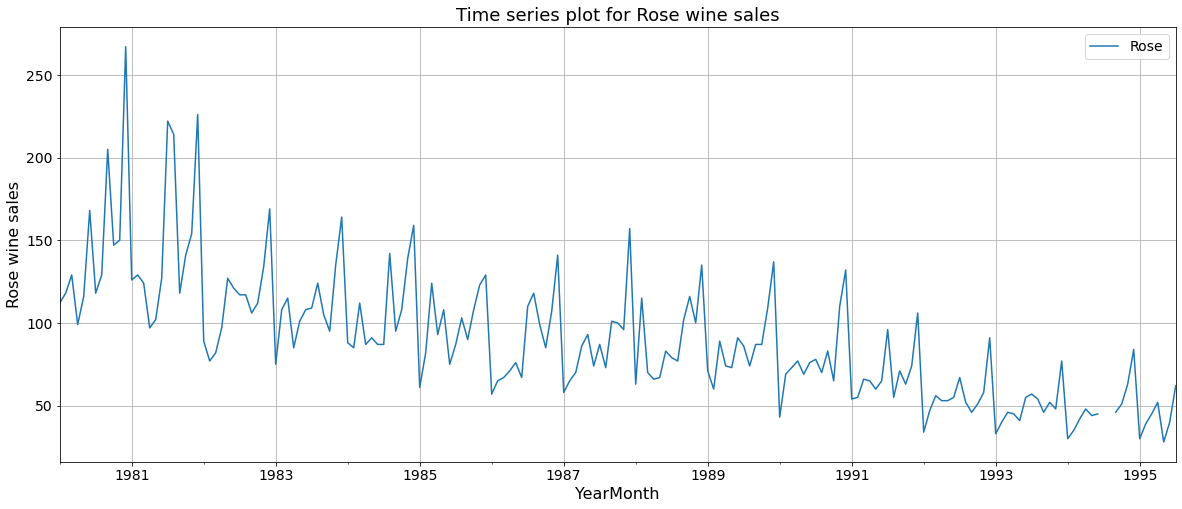

In [770]:
df1.plot(grid=True , fontsize=14)
plt.xlabel('YearMonth', fontsize=16)
plt.ylabel('Rose wine sales', fontsize=16)

plt.legend(fontsize=14)
plt.title('Time series plot for Rose wine sales', fontsize=18)
plt.show()

# 1.2)

## EDA :

In [771]:
print('Total number of rows in the dataset:',df1.shape[0])
print('Total number of columns in the dataset:',df1.shape[1])

Total number of rows in the dataset: 187
Total number of columns in the dataset: 1


In [772]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    185 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


### Checking the basic measures of descriptive statistics of the Time Series data :

In [773]:
round(df1.describe(),3)

,Rose
count,185.000
mean,90.395
std,39.175
min,28.000
25%,63.000
50%,86.000
75%,112.000
max,267.000


In [774]:
print('Number of null or missing values in the dataset:\n',df1.isnull().sum())

Number of null or missing values in the dataset:
 Rose    2
dtype: int64


In [775]:
df1[df1.index.year==1994]

,Rose
YearMonth,
1994-01-01,30.0
1994-02-01,35.0
1994-03-01,42.0
1994-04-01,48.0
1994-05-01,44.0
1994-06-01,45.0
1994-07-01,NaN
1994-08-01,NaN
1994-09-01,46.0


Since there seems to be yearly seasonality component in our data, we have taken the same into account for calculating the seasonal averages.

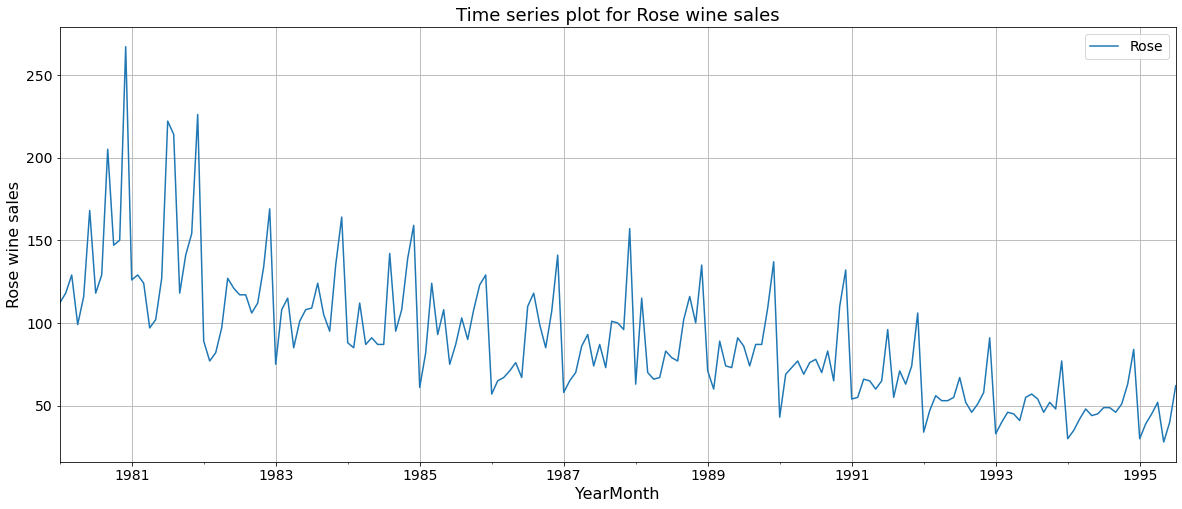

In [776]:
# Calculate seasonal averages
seasonal_averages = df1.groupby(df1.index.year).transform('mean')

# Replace missing values with seasonal averages
df1 = df1.combine_first(seasonal_averages)
df1.plot(grid=True , fontsize=14)
plt.xlabel('YearMonth', fontsize=16)
plt.ylabel('Rose wine sales', fontsize=16)

plt.legend(fontsize=14)
plt.title('Time series plot for Rose wine sales', fontsize=18)
plt.show()

## Yearly boxplot

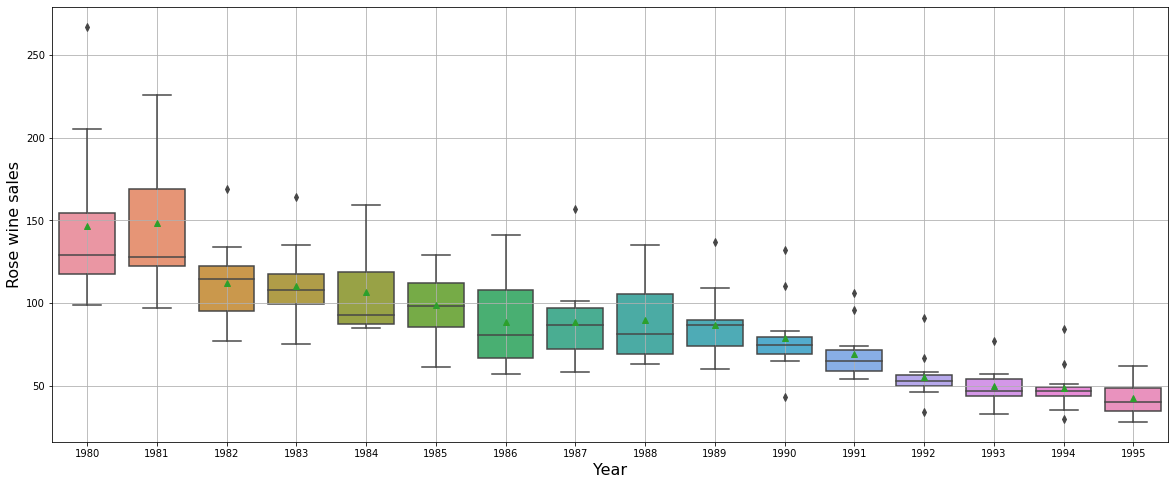

In [777]:
sns.boxplot(x = df1.index.year,y = df1['Rose'], showmeans=True)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Rose wine sales', fontsize=16)
plt.grid();

## Monthly boxplot

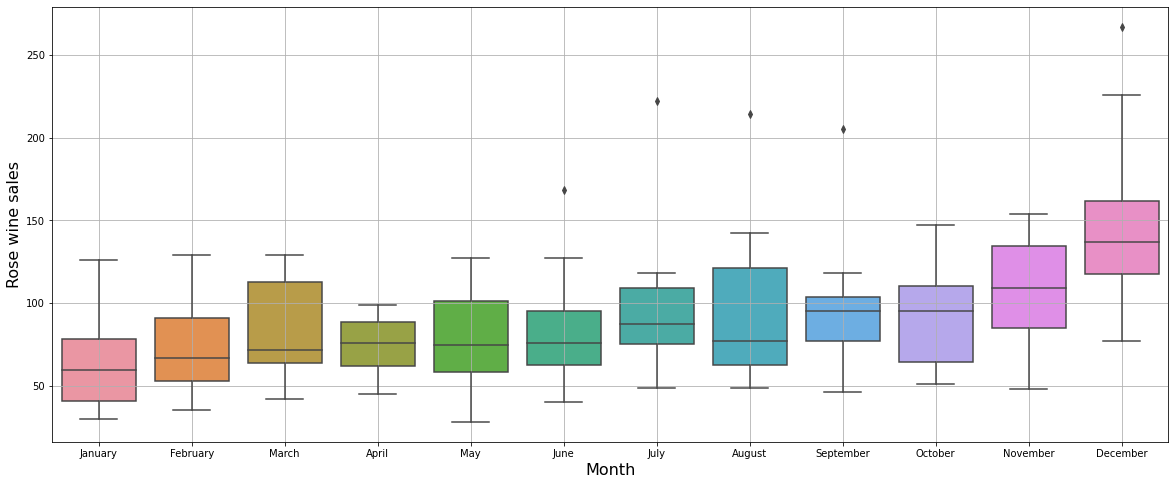

In [778]:
sns.boxplot(x = df1.index.month_name(),y = df1['Rose'])
plt.xlabel('Month', fontsize=16)
plt.ylabel('Rose wine sales', fontsize=16)
plt.grid();

### Plotting graph of monthly Wine Sales across years:

In [779]:
monthly_sales = pd.pivot_table(df1, values = 'Rose', columns = df1.index.month, index = df1.index.year)
monthly_sales

YearMonth,1,2,3,4,5,6,7,8,9,10,11,12
YearMonth,,,,,,,,,,,,
1980,112.0,118.0,129.0,99.0,116.0,168.0,118.0,129.0,205.0,147.0,150.0,267.0
1981,126.0,129.0,124.0,97.0,102.0,127.0,222.0,214.0,118.0,141.0,154.0,226.0
1982,89.0,77.0,82.0,97.0,127.0,121.0,117.0,117.0,106.0,112.0,134.0,169.0
1983,75.0,108.0,115.0,85.0,101.0,108.0,109.0,124.0,105.0,95.0,135.0,164.0
1984,88.0,85.0,112.0,87.0,91.0,87.0,87.0,142.0,95.0,108.0,139.0,159.0
1985,61.0,82.0,124.0,93.0,108.0,75.0,87.0,103.0,90.0,108.0,123.0,129.0
1986,57.0,65.0,67.0,71.0,76.0,67.0,110.0,118.0,99.0,85.0,107.0,141.0
1987,58.0,65.0,70.0,86.0,93.0,74.0,87.0,73.0,101.0,100.0,96.0,157.0
1988,63.0,115.0,70.0,66.0,67.0,83.0,79.0,77.0,102.0,116.0,100.0,135.0


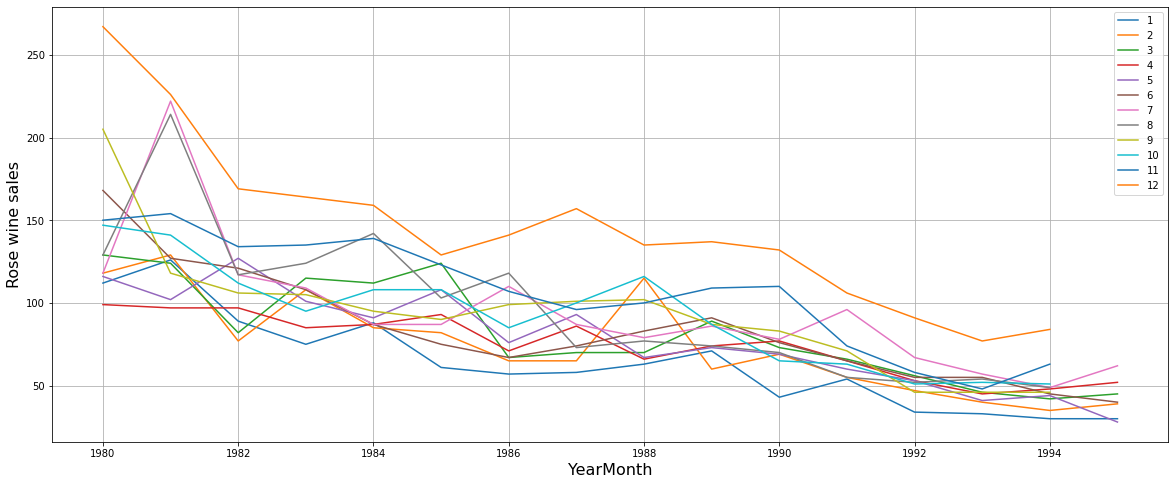

In [780]:
monthly_sales.plot()
plt.xlabel('YearMonth', fontsize=16)
plt.ylabel('Rose wine sales', fontsize=16)
plt.grid()
plt.legend(loc='best');

### Plotting the Empirical Cumulative Distribution:

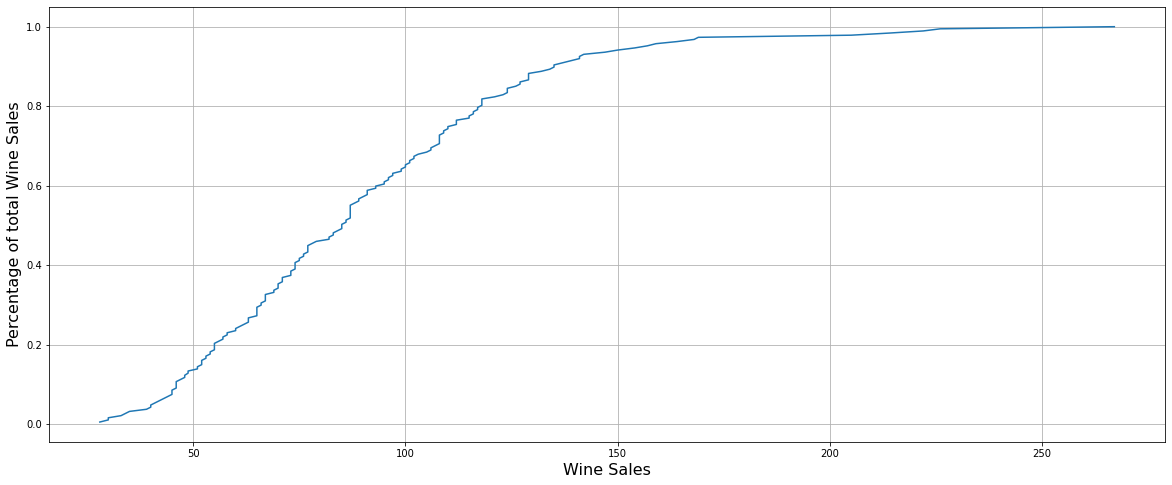

In [781]:
from statsmodels.distributions.empirical_distribution import ECDF

cdf = ECDF(df1['Rose'])
plt.plot(cdf.x, cdf.y);
plt.grid()
plt.ylabel('Percentage of total Wine Sales', fontsize=16);
plt.xlabel('Wine Sales', fontsize=16);

## Performing Decomposition :

### Additive Decomposition :

In [782]:
df1_add_decompose = seasonal_decompose(df1, model = 'additive')

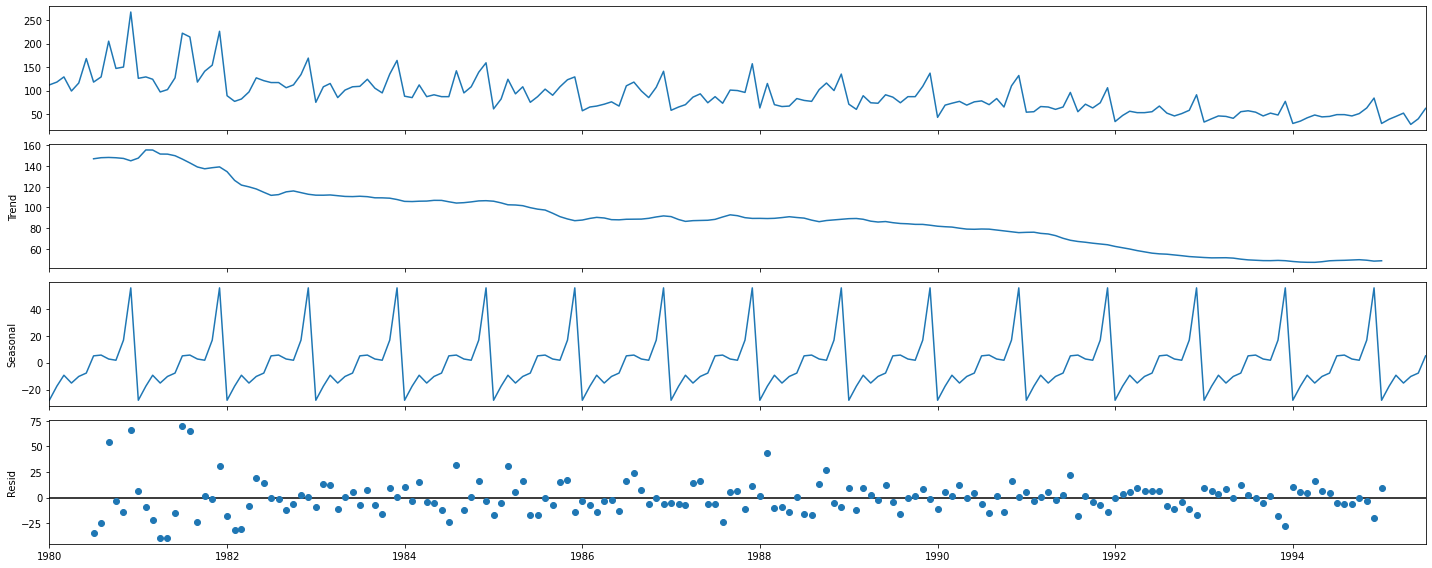

In [783]:
df1_add_decompose.plot();
plt.show()


### Multiplicative Decomposition :

In [784]:
df1_mult_decompose = seasonal_decompose(df1, model = 'multiplicative')

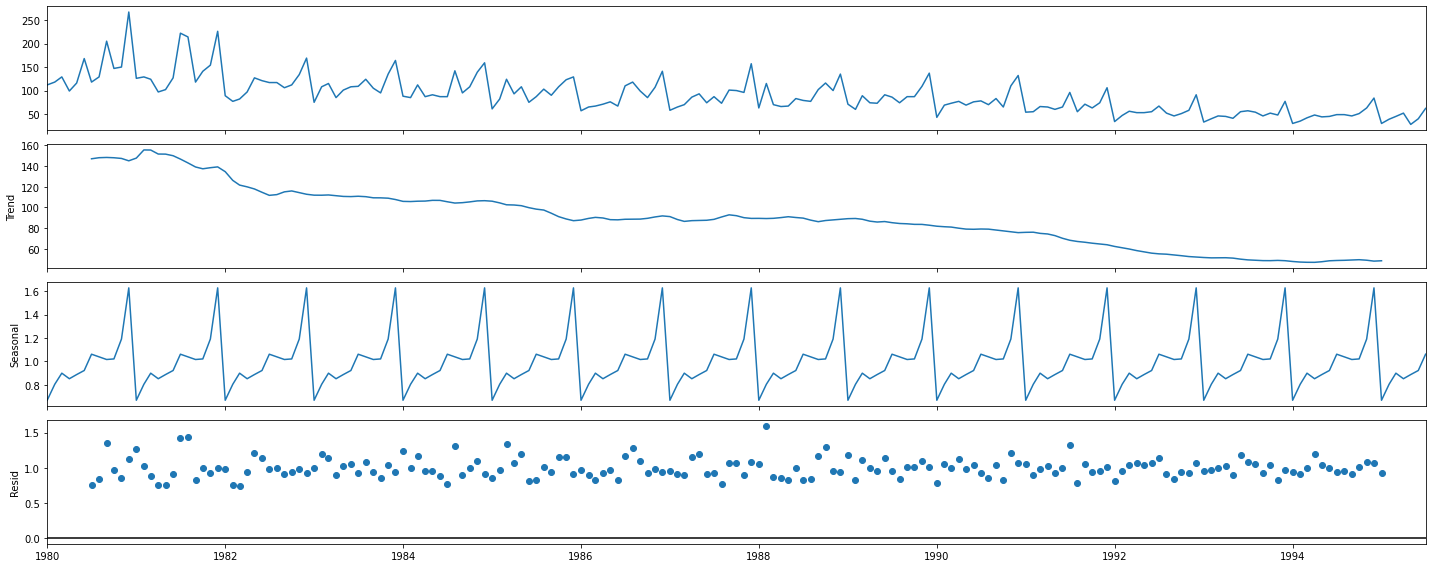

In [785]:
df1_mult_decompose.plot()
plt.show()

# 1.3)

## Splitting the data into train and test and plotting the train and test data. [Test data should start in 1991]

In [786]:
train = df1[df1.index<'1991'] 
test  = df1[df1.index>='1991']

In [787]:
print(df1.shape)
print(train.shape)
print(test.shape)

(187, 1)
(132, 1)
(55, 1)


In [788]:
print('Total number of rows in the training dataset:',train.shape[0])
print('Total number of columns in the training dataset:',train.shape[1])

Total number of rows in the training dataset: 132
Total number of columns in the training dataset: 1


In [789]:
print('Total number of rows in the testing dataset:',test.shape[0])
print('Total number of columns in the testing dataset:',test.shape[1])

Total number of rows in the testing dataset: 55
Total number of columns in the testing dataset: 1


In [790]:
from IPython.display import display

In [791]:
print('First few rows of Training Data')
display(train.head())
print('\n\n')
print('Last few rows of Training Data')
display(train.tail())
print('\n\n')
print('First few rows of Test Data')
display(test.head())
print('\n\n')
print('Last few rows of Test Data')
display(test.tail())

First few rows of Training Data


,Rose
YearMonth,
1980-01-01,112.0
1980-02-01,118.0
1980-03-01,129.0
1980-04-01,99.0
1980-05-01,116.0





Last few rows of Training Data


,Rose
YearMonth,
1990-08-01,70.0
1990-09-01,83.0
1990-10-01,65.0
1990-11-01,110.0
1990-12-01,132.0





First few rows of Test Data


,Rose
YearMonth,
1991-01-01,54.0
1991-02-01,55.0
1991-03-01,66.0
1991-04-01,65.0
1991-05-01,60.0





Last few rows of Test Data


,Rose
YearMonth,
1995-03-01,45.0
1995-04-01,52.0
1995-05-01,28.0
1995-06-01,40.0
1995-07-01,62.0


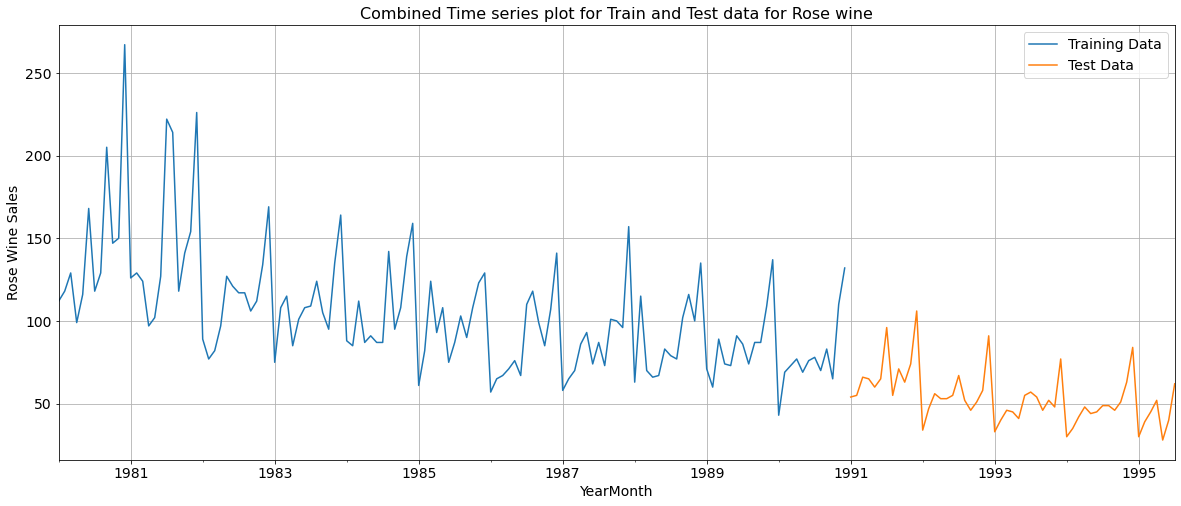

In [792]:
train['Rose'].plot(fontsize=14)
test['Rose'].plot(fontsize=14)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose Wine Sales', fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'], fontsize=14)
plt.title('Combined Time series plot for Train and Test data for Rose wine', fontsize=16)
plt.show()

----

-----

# 1.4) Building different models and checking their performance metrics using RMSE

## Model 1: Linear Regression

We know that Linear regression needs at least one independent variable X to explain the target variable, Y but here we only have one variable available that is Wine sales 'Sparkling', as we converted the date-time variable into the index. So now we will define an independent variable by assigning it to a new column 'time' both for train and test data

In [793]:
print(df1.shape)
print(train.shape)
print(test.shape)

(187, 1)
(132, 1)
(55, 1)


In [794]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+133 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('\n')
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]


Test Time instance 
 [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


We see that we have successfully the generated the numerical time instance order for both the training and test set. Now we will add these values in the training and test set.

In [795]:
LnR_train = train.copy()
LnR_test = test.copy()

In [796]:
LnR_train['time'] = train_time
LnR_test['time'] = test_time

print('First few rows of Training Data')
display(LnR_train.head())
print('Last few rows of Training Data')
display(LnR_train.tail())
print('First few rows of Test Data')
display(LnR_test.head())
print('Last few rows of Test Data')
display(LnR_test.tail())

First few rows of Training Data


,Rose,time
YearMonth,,
1980-01-01,112.0,1
1980-02-01,118.0,2
1980-03-01,129.0,3
1980-04-01,99.0,4
1980-05-01,116.0,5


Last few rows of Training Data


,Rose,time
YearMonth,,
1990-08-01,70.0,128
1990-09-01,83.0,129
1990-10-01,65.0,130
1990-11-01,110.0,131
1990-12-01,132.0,132


First few rows of Test Data


,Rose,time
YearMonth,,
1991-01-01,54.0,133
1991-02-01,55.0,134
1991-03-01,66.0,135
1991-04-01,65.0,136
1991-05-01,60.0,137


Last few rows of Test Data


,Rose,time
YearMonth,,
1995-03-01,45.0,183
1995-04-01,52.0,184
1995-05-01,28.0,185
1995-06-01,40.0,186
1995-07-01,62.0,187


Now that our training and test data has been modified, let us go ahead use Linear Regression to build the model on the training data and test the model on the test data.

#### Fitting the Linear model:

In [797]:
lr = LinearRegression()

In [798]:
lr.fit(LnR_train[['time']],LnR_train['Rose'])

LinearRegression()

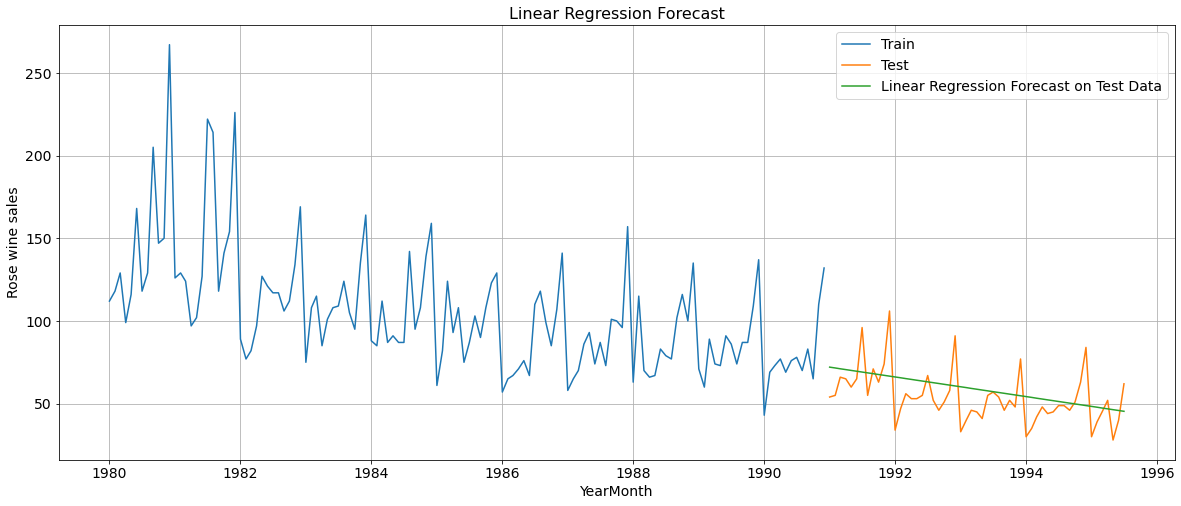

In [799]:
train_predict_model1   = lr.predict(LnR_train[['time']])
LnR_train['LnR_forecast'] = train_predict_model1

test_predict_model1    = lr.predict(LnR_test[['time']])
LnR_test['LnR_forecast']  = test_predict_model1

plt.plot( train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(LnR_test['LnR_forecast'], label='Linear Regression Forecast on Test Data')

plt.legend(loc='best', fontsize=14)
plt.title('Linear Regression Forecast', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose wine sales', fontsize=14)
plt.grid();

In [800]:
LnR_test.head()

,Rose,time,LnR_forecast
YearMonth,,,
1991-01-01,54.0,133,72.063266
1991-02-01,55.0,134,71.568888
1991-03-01,66.0,135,71.074511
1991-04-01,65.0,136,70.580133
1991-05-01,60.0,137,70.085755


#### Defining the functions for calculating the accuracy metrics.

### Model Evaluation

In [801]:
rmse_model1_test = mse(test['Rose'],test_predict_model1,squared=False)
print("For Linear Regression forecast on the Test Data,  RMSE is %3.3f " %(rmse_model1_test))

For Linear Regression forecast on the Test Data,  RMSE is 15.238 


In [802]:
resultsDf = pd.DataFrame({'Test RMSE': [rmse_model1_test]},index=['LnR_forecast'])
resultsDf

,Test RMSE
LnR_forecast,15.238125


----

## Model 2: Naive Approach: 

#### In the Naive model, the prediction for tomorrow is the same as today and the prediction for day after tomorrow is same as tomorrow and therefore as the prediction of tomorrow is same as today, the prediction for day after tomorrow should also be today by following the logic.

In [803]:
Naive_train = train.copy()
Naive_test = test.copy()

In [804]:
len(train['Rose'])

132

In [805]:
Naive_test['naive'] = train['Rose'][len(train['Rose'])-1]
Naive_test.head()

,Rose,naive
YearMonth,,
1991-01-01,54.0,132.0
1991-02-01,55.0,132.0
1991-03-01,66.0,132.0
1991-04-01,65.0,132.0
1991-05-01,60.0,132.0


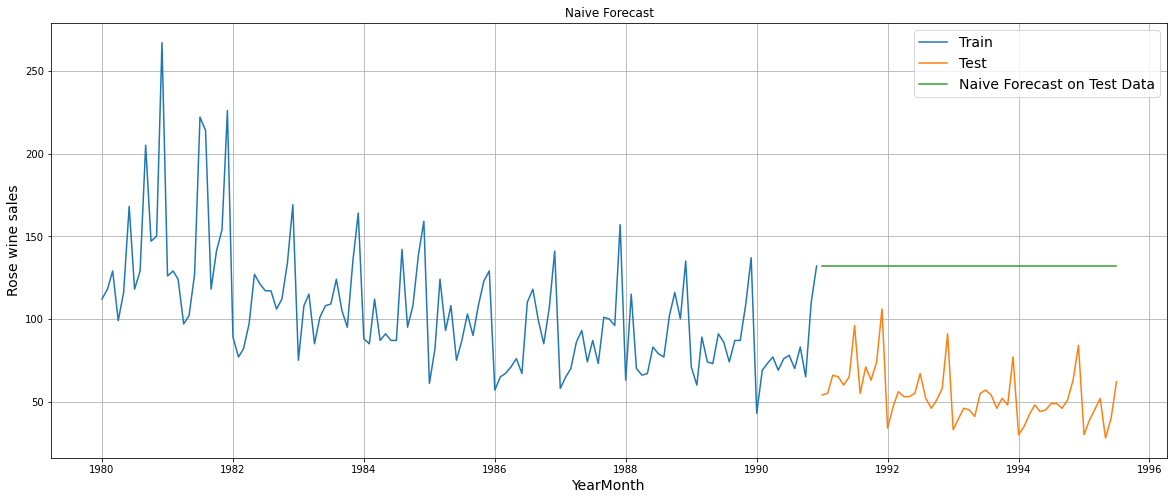

In [806]:
plt.plot(Naive_train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')

plt.plot(Naive_test['naive'], label='Naive Forecast on Test Data')

plt.legend(loc='best', fontsize=14)
plt.title("Naive Forecast")
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose wine sales', fontsize=14)
plt.grid();

### Model Evaluation

In [807]:
rmse_model2_test = mse(test['Rose'],Naive_test['naive'],squared=False)
print("For Naive forecast on the Test Data,  RMSE is %3.3f" %(rmse_model2_test))

For Naive forecast on the Test Data,  RMSE is 79.591


In [808]:
resultsDf_2 = pd.DataFrame({'Test RMSE': [rmse_model2_test]},index=['Naive_forecast'])

resultsDf = pd.concat([resultsDf, resultsDf_2])
resultsDf

,Test RMSE
LnR_forecast,15.238125
Naive_forecast,79.590941


---

## Model 3: Simple Average

#### In simple average method, we forecast by simply using the average of the training values.

In [809]:
SimpAvg_train = train.copy()
SimpAvg_test = test.copy()

In [810]:
SimpAvg_test['mean_forecast'] = train['Rose'].mean()
SimpAvg_test.head()

,Rose,mean_forecast
YearMonth,,
1991-01-01,54.0,104.939394
1991-02-01,55.0,104.939394
1991-03-01,66.0,104.939394
1991-04-01,65.0,104.939394
1991-05-01,60.0,104.939394


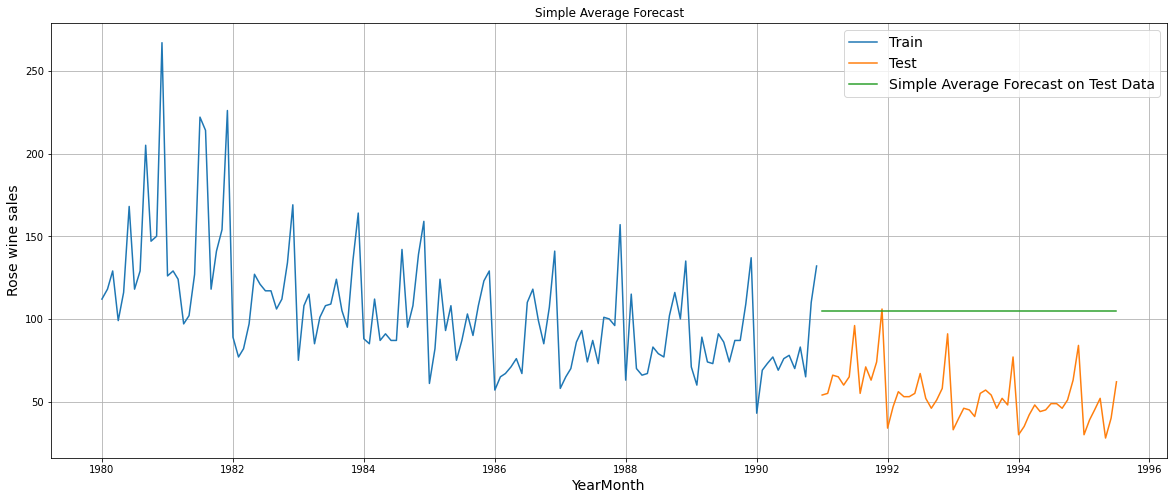

In [811]:
plt.plot(SimpAvg_train['Rose'], label='Train')
plt.plot(SimpAvg_test['Rose'], label='Test')

plt.plot(SimpAvg_test['mean_forecast'], label='Simple Average Forecast on Test Data')

plt.legend(loc='best', fontsize=14)
plt.title("Simple Average Forecast")
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose wine sales', fontsize=14)
plt.grid();

### Model Evaluation

In [812]:
rmse_model3_test = mse(test['Rose'],SimpAvg_test['mean_forecast'],squared=False)
print("For Simple Average forecast on the Test Data,  RMSE is %3.3f" %(rmse_model3_test))

For Simple Average forecast on the Test Data,  RMSE is 53.331


In [813]:
resultsDf_3 = pd.DataFrame({'Test RMSE': [rmse_model3_test]}
                           ,index=['SimpleAvg_forecast'])

resultsDf = pd.concat([resultsDf, resultsDf_3])
resultsDf

,Test RMSE
LnR_forecast,15.238125
Naive_forecast,79.590941
SimpleAvg_forecast,53.330686


----

## Model 4: Simple Exponential Smoothing 

In [814]:
ses = SimpleExpSmoothing(train,initialization_method='estimated')
ses_autofit = ses.fit(optimized=True)

Fitting the Simple Exponential Smoothing model and asking python to choose the optimal parameters


In [815]:
ses_autofit.params

{'smoothing_level': 0.09874984934176041,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 134.3869637432864,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Using the fitted model on the training set to forecast on the test set

In [816]:
ses_predict = ses_autofit.forecast(steps=len(test))
ses_predict.head()

1991-01-01    87.104998
1991-02-01    87.104998
1991-03-01    87.104998
1991-04-01    87.104998
1991-05-01    87.104998
Freq: MS, dtype: float64

Plotting the Training data, Test data and the forecasted values

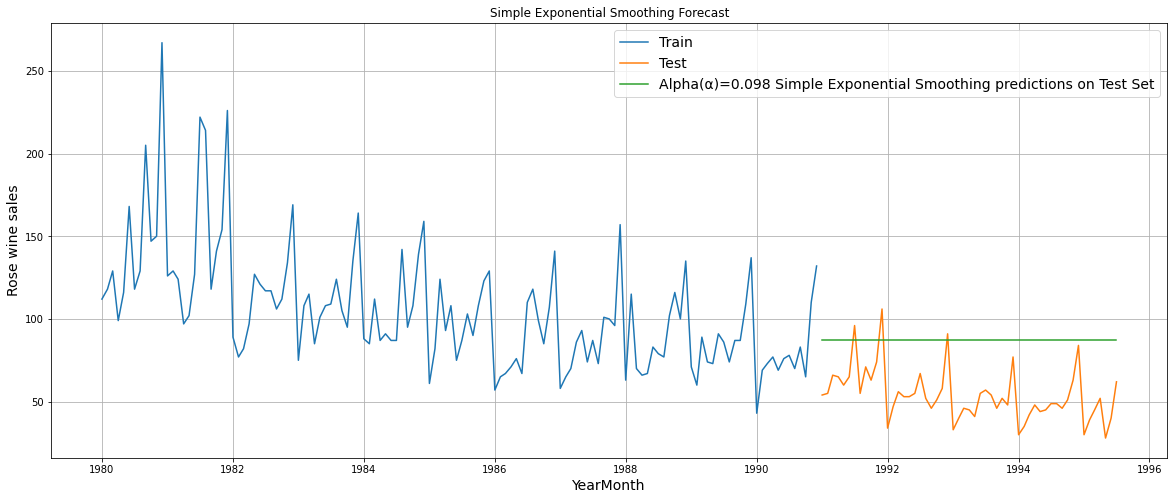

In [817]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')

plt.plot(ses_predict, label='Alpha(⍺)=0.098 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best', fontsize=14)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose wine sales', fontsize=14)
plt.grid()
plt.title('Simple Exponential Smoothing Forecast');

In [818]:
rmse_model4_test = mse(test['Rose'],ses_predict,squared=False)
print("For Simple Exponential Smoothing forecast on the Test Data,  RMSE is %3.3f" %(rmse_model4_test))

For Simple Exponential Smoothing forecast on the Test Data,  RMSE is 36.666


In [819]:
resultsDf_4 = pd.DataFrame({'Test RMSE': [rmse_model4_test]}
                           ,index=['Simple_Exp_Smoothing_forecast'])

resultsDf = pd.concat([resultsDf, resultsDf_4])
resultsDf

,Test RMSE
LnR_forecast,15.238125
Naive_forecast,79.590941
SimpleAvg_forecast,53.330686
Simple_Exp_Smoothing_forecast,36.665694


---

## Model 5: Double Exponential Smoothing 

Initializing and fitting the Double Exponential Smoothing Model

In [820]:
hlt = Holt(train,initialization_method='estimated')
des = hlt.fit()
print(des.params)

{'smoothing_level': 9.90185222353006e-08, 'smoothing_trend': 0.0, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 137.82123005224759, 'initial_trend': -0.4943936312659171, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


Forecasting using this model for the duration of the test set

In [821]:
des_predict =  des.forecast(len(test))
des_predict.head()

1991-01-01    72.066877
1991-02-01    71.572483
1991-03-01    71.078090
1991-04-01    70.583696
1991-05-01    70.089303
Freq: MS, dtype: float64

Plotting the Training data, Test data and the forecasted values

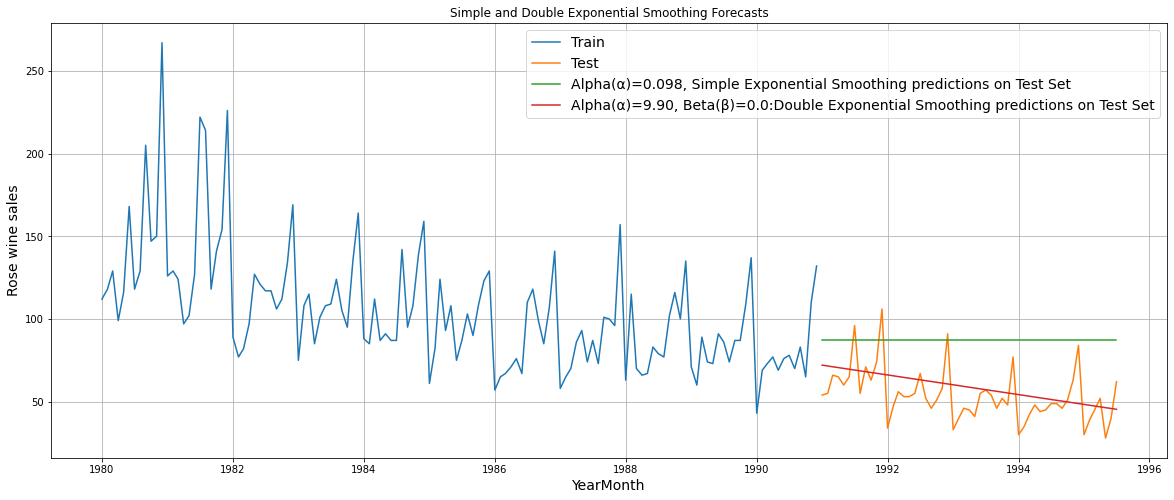

In [822]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')

plt.plot(ses_predict, label='Alpha(⍺)=0.098, Simple Exponential Smoothing predictions on Test Set')
plt.plot(des_predict, label='Alpha(⍺)=9.90, Beta(β)=0.0:Double Exponential Smoothing predictions on Test Set')

plt.legend(loc='best', fontsize=14)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose wine sales', fontsize=14)
plt.grid()
plt.title('Simple and Double Exponential Smoothing Forecasts');

In [823]:
rmse_model5_test = mse(test['Rose'],des_predict,squared=False)
print("For Double Exponential Smoothing forecast on the Test Data,  RMSE is %3.3f" %(rmse_model5_test))


For Double Exponential Smoothing forecast on the Test Data,  RMSE is 15.239


In [824]:
resultsDf_5 = pd.DataFrame({'Test RMSE': [rmse_model5_test]}
                           ,index=['Double_Exp_Smoothing_forecast'])

resultsDf = pd.concat([resultsDf, resultsDf_5])
resultsDf

,Test RMSE
LnR_forecast,15.238125
Naive_forecast,79.590941
SimpleAvg_forecast,53.330686
Simple_Exp_Smoothing_forecast,36.665694
Double_Exp_Smoothing_forecast,15.239142


### Inference: 

Here, we see that the Double Exponential Smoothing has actually done worse when compared to the Simple Exponential Smoothing. This may be because of the fact that the Double Exponential Smoothing model has picked up the trend component but ignored seasonality which has a strong presence in this data.



----

## Triple Exponential Smoothing 

## Model 6: Holt Winter's linear method with additive errors 

Initializing and fitting the Triple Exponential Smoothing Model


In [825]:
tes_add = ExponentialSmoothing(train,trend='additive',seasonal='additive',initialization_method='estimated')
tes_add_autofit = tes_add.fit()
print(tes_add.params)

{'smoothing_level': 0.08879273709666283, 'smoothing_trend': 5.480169197480449e-05, 'smoothing_seasonal': 0.0009800321321151695, 'damping_trend': nan, 'initial_level': 146.627006967135, 'initial_trend': -0.5479322109552787, 'initial_seasons': array([-31.19009793, -18.82390191, -10.83142432, -21.47008114,
       -12.65943946,  -7.19483036,   2.6988831 ,   8.80644578,
         4.81722258,   2.91726448,  21.00561884,  63.25544695]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


Forecasting using this model for the duration of the test set


In [826]:
tes_add_predict =  tes_add_autofit.forecast(len(test))
tes_add_predict.head()

1991-01-01    42.644702
1991-02-01    54.463141
1991-03-01    61.907679
1991-04-01    50.721381
1991-05-01    58.983879
Freq: MS, dtype: float64

Plotting the Training data, Test data and the forecasted values


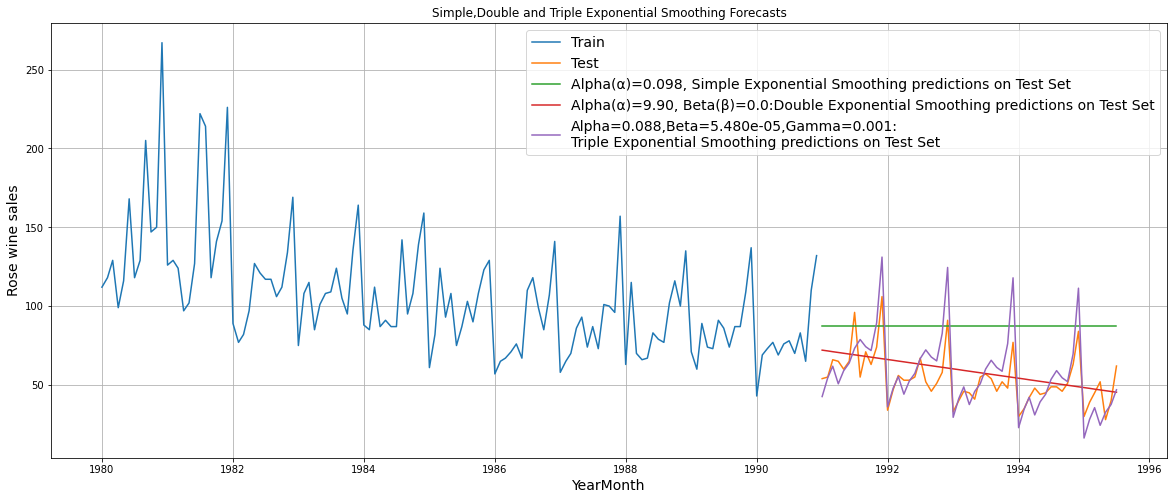

In [827]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')

plt.plot(ses_predict, label='Alpha(⍺)=0.098, Simple Exponential Smoothing predictions on Test Set')
plt.plot(des_predict, label='Alpha(⍺)=9.90, Beta(β)=0.0:Double Exponential Smoothing predictions on Test Set')


plt.plot(tes_add_predict, label='Alpha=0.088,Beta=5.480e-05,Gamma=0.001:\nTriple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best', fontsize=14)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose wine sales', fontsize=14)
plt.grid()
plt.title('Simple,Double and Triple Exponential Smoothing Forecasts');

#### We see that the Triple Exponential Smoothing is picking up the seasonal component pretty well.

### Model Evaluation

In [828]:
rmse_model6_test = mse(test['Rose'],tes_add_predict,squared=False)
print("For Triple Exponential additive Smoothing forecast on the Test Data,  RMSE is %3.3f" %(rmse_model6_test))


For Triple Exponential additive Smoothing forecast on the Test Data,  RMSE is 14.186


In [829]:
resultsDf_6 = pd.DataFrame({'Test RMSE': [rmse_model6_test]}
                           ,index=['Triple_Exp_additive_Smoothing_forecast'])

resultsDf = pd.concat([resultsDf, resultsDf_6])
resultsDf

,Test RMSE
LnR_forecast,15.238125
Naive_forecast,79.590941
SimpleAvg_forecast,53.330686
Simple_Exp_Smoothing_forecast,36.665694
Double_Exp_Smoothing_forecast,15.239142
Triple_Exp_additive_Smoothing_forecast,14.186164


## Model 6.1: Brute forced triple exponential smoothing with additive errors:

In [830]:
hw_train= train.copy()
hw_test= test.copy()

In [831]:
metrics1 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Test RMSE': []})
metrics1

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE


In [832]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            metrics1_i_j_k = tes_add.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            hw_train['predict',i,j,k] = metrics1_i_j_k.fittedvalues
            hw_test['predict',i,j,k] = metrics1_i_j_k.forecast(steps=len(test))
        
            rmse_model7_1_train = mse(hw_train['Rose'],hw_train['predict',i,j,k],squared=False)
            
            rmse_model7_1_test = mse(hw_test['Rose'],hw_test['predict',i,j,k],squared=False)
    
            metrics1 = pd.concat([metrics1, pd.DataFrame({'Alpha Values': i, 'Beta Values': j, 'Gamma Values': k,
                                                          'Train RMSE': rmse_model7_1_train, 'Test RMSE': rmse_model7_1_test},
                                                         index=[0])], ignore_index=True)
    



In [833]:
metrics1

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE
0,0.3,0.3,0.3,24.279693,1.296631e+01
1,0.3,0.3,0.4,25.308660,1.276483e+01
2,0.3,0.3,0.5,26.805188,3.986141e+01
3,0.3,0.3,0.6,28.844821,1.136380e+02
4,0.3,0.3,0.7,31.521298,2.035291e+02
...,...,...,...,...,...
507,1.0,1.0,0.6,2005.858333,3.397533e+04
508,1.0,1.0,0.7,7447.070502,8.766183e+04
509,1.0,1.0,0.8,25743.870344,8.166526e+05
510,1.0,1.0,0.9,80677.424683,3.575054e+06


In [834]:
metrics1.sort_values(by=['Test RMSE']).head()


,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE
1,0.3,0.3,0.4,25.308660,12.764834
0,0.3,0.3,0.3,24.279693,12.966313
64,0.4,0.3,0.3,25.447354,13.376827
129,0.5,0.3,0.4,27.934042,18.090213
8,0.3,0.4,0.3,25.249967,23.560322


Plotting on both the Training and Test data using brute force alpha, beta and gamma determination


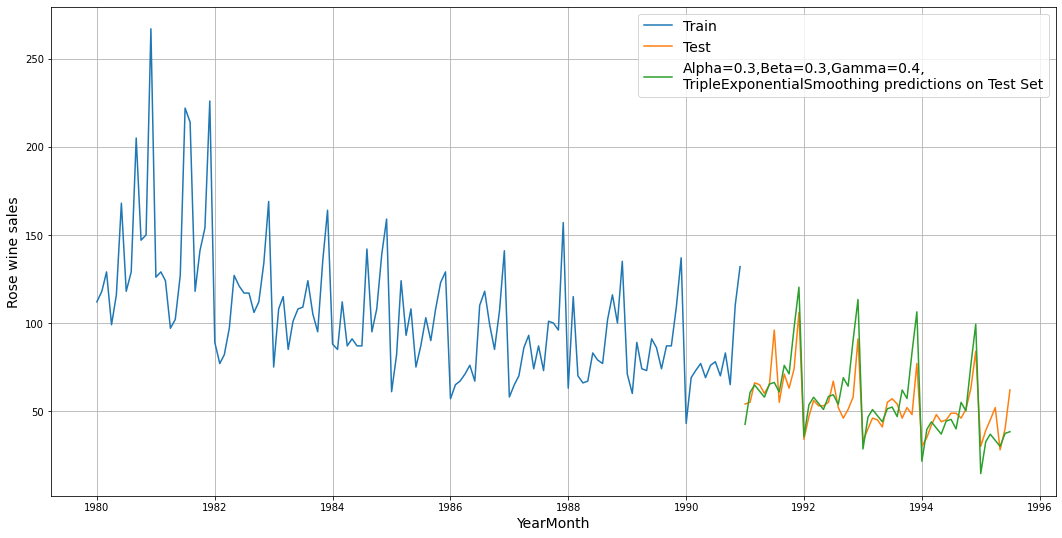

In [835]:
plt.figure(figsize=(18,9))
plt.plot(train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')

plt.plot(hw_test['predict', 0.3, 0.3, 0.4], label='Alpha=0.3,Beta=0.3,Gamma=0.4,\nTripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best', fontsize=14)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose wine sales', fontsize=14)
plt.grid();

In [836]:
metrics1.sort_values(by=['Test RMSE']).values[0][4]

12.764833759989155

-----

## Model 7: Holt Winter's linear method with multiplicative errors

In [837]:
tes_mult = ExponentialSmoothing(train,trend='add',seasonal='multiplicative',initialization_method='estimated')
tes_mult_autofit = tes_mult.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(tes_mult.params)


==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.07723664368922872, 'smoothing_trend': 0.04004327855525937, 'smoothing_seasonal': 0.0008597314184938012, 'damping_trend': nan, 'initial_level': 150.88880327964617, 'initial_trend': -0.8730507584210621, 'initial_seasons': array([0.74299366, 0.84221021, 0.92101993, 0.80485339, 0.9053558 ,
       0.98501924, 1.08361094, 1.15483473, 1.09061707, 1.06893727,
       1.2459978 , 1.71775241]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


Forecasting using this model for the duration of the test set


In [838]:
tes_mult_predict =  tes_mult_autofit.forecast(len(test))
tes_mult_predict.head()

1991-01-01    55.985997
1991-02-01    63.273975
1991-03-01    68.950518
1991-04-01    60.062252
1991-05-01    67.302342
Freq: MS, dtype: float64

Plotting the Training data, Test data and the forecasted values


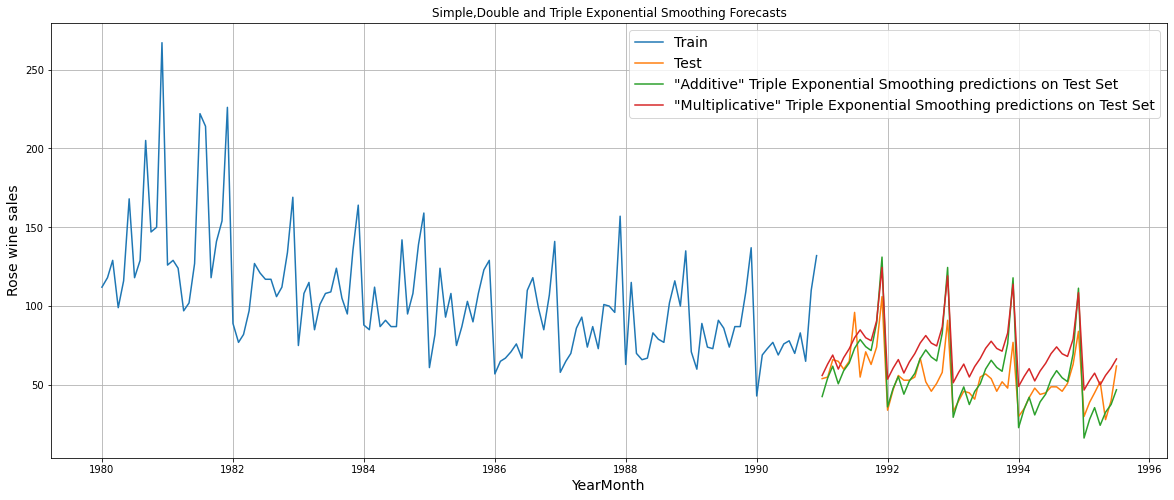

In [839]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')


plt.plot(tes_add_predict, label='"Additive" Triple Exponential Smoothing predictions on Test Set')
plt.plot(tes_mult_predict, label='"Multiplicative" Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best', fontsize=14)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose wine sales', fontsize=14)
plt.grid()
plt.title('Simple,Double and Triple Exponential Smoothing Forecasts');

Plotting exclusively for Test data and the forecasted values


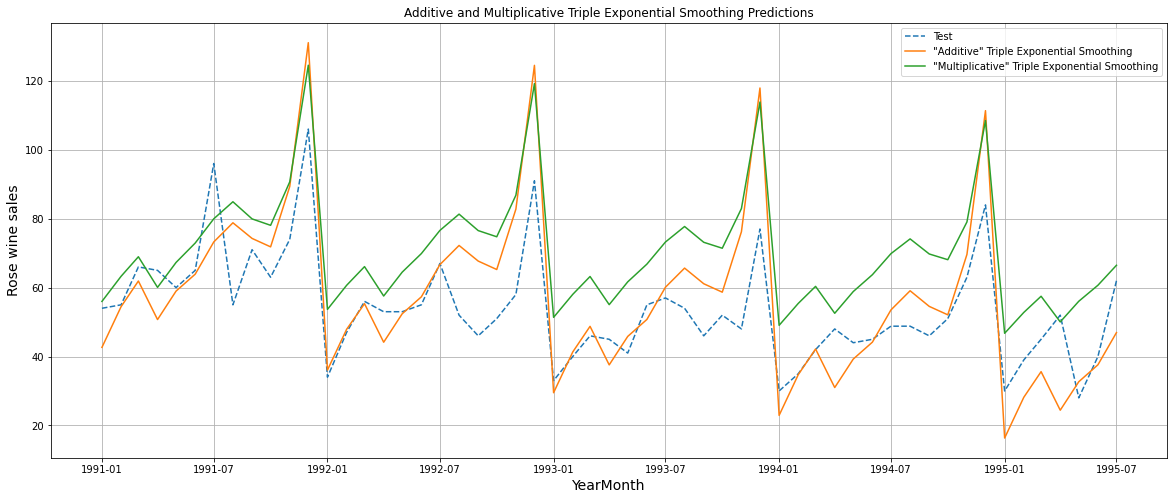

In [840]:
plt.plot(test, linestyle='dashed', label='Test')
plt.plot(tes_add_predict, label='"Additive" Triple Exponential Smoothing')
plt.plot(tes_mult_predict, label='"Multiplicative" Triple Exponential Smoothing')

plt.legend(loc='best', fontsize=10)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose wine sales', fontsize=14)
plt.grid()
plt.title('Additive and Multiplicative Triple Exponential Smoothing Predictions');

### Model Evaluation

In [841]:
rmse_model7_test = mse(test['Rose'],tes_mult_predict,squared=False)
print("For Triple Exponential multiplicative Smoothing forecast on the Test Data,  RMSE is %3.3f" %(rmse_model7_test))


For Triple Exponential multiplicative Smoothing forecast on the Test Data,  RMSE is 19.042


In [842]:
resultsDf_7 = pd.DataFrame({'Test RMSE': [rmse_model7_test]}
                           ,index=['Triple_Exp_multiplicative_Smoothing_forecast'])

resultsDf = pd.concat([resultsDf, resultsDf_7])
resultsDf

,Test RMSE
LnR_forecast,15.238125
Naive_forecast,79.590941
SimpleAvg_forecast,53.330686
Simple_Exp_Smoothing_forecast,36.665694
Double_Exp_Smoothing_forecast,15.239142
Triple_Exp_additive_Smoothing_forecast,14.186164
Triple_Exp_multiplicative_Smoothing_forecast,19.041869


-----

## Model 8: Using Brute force method i.e. best parameters (alpha, beta and gamma) for Holt Winter's linear method with multiplicative errors 

In [843]:
hw_train= train.copy()
hw_test= test.copy()

In [844]:
metrics2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Test RMSE': []})
metrics2

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE


In [845]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            metrics2_i_j_k = tes_mult.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            hw_train['predict',i,j,k] = metrics2_i_j_k.fittedvalues
            hw_test['predict',i,j,k] = metrics2_i_j_k.forecast(steps=len(test))
        
            rmse_model8_train = mse(hw_train['Rose'],hw_train['predict',i,j,k],squared=False)
            
            rmse_model8_test = mse(hw_test['Rose'],hw_test['predict',i,j,k],squared=False)
    
            metrics2 = pd.concat([metrics2, pd.DataFrame({'Alpha Values': i, 'Beta Values': j, 'Gamma Values': k,
                                                          'Train RMSE': rmse_model8_train, 'Test RMSE': rmse_model8_test},
                                                         index=[0])], ignore_index=True)
    



In [846]:
metrics2

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE
0,0.3,0.3,0.3,23.344917,19.573410
1,0.3,0.3,0.4,24.588120,10.215033
2,0.3,0.3,0.5,26.190281,31.909359
3,0.3,0.3,0.6,28.250682,81.482462
4,0.3,0.3,0.7,30.948221,153.368782
...,...,...,...,...,...
507,1.0,1.0,0.6,2140.632923,6630.608711
508,1.0,1.0,0.7,3091.001599,9721.042850
509,1.0,1.0,0.8,2438.212926,2573.863709
510,1.0,1.0,0.9,28835.801100,3522.901171


In [847]:
metrics2.sort_values(by=['Test RMSE']).head()


,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE
1,0.3,0.3,0.4,24.588120,10.215033
9,0.3,0.4,0.4,25.599445,10.454836
80,0.4,0.5,0.3,26.917917,13.532298
24,0.3,0.6,0.3,25.815213,15.418489
194,0.6,0.3,0.5,31.758130,17.224502


Plotting the Training and Test data using brute force method for alpha, beta and gamma determination


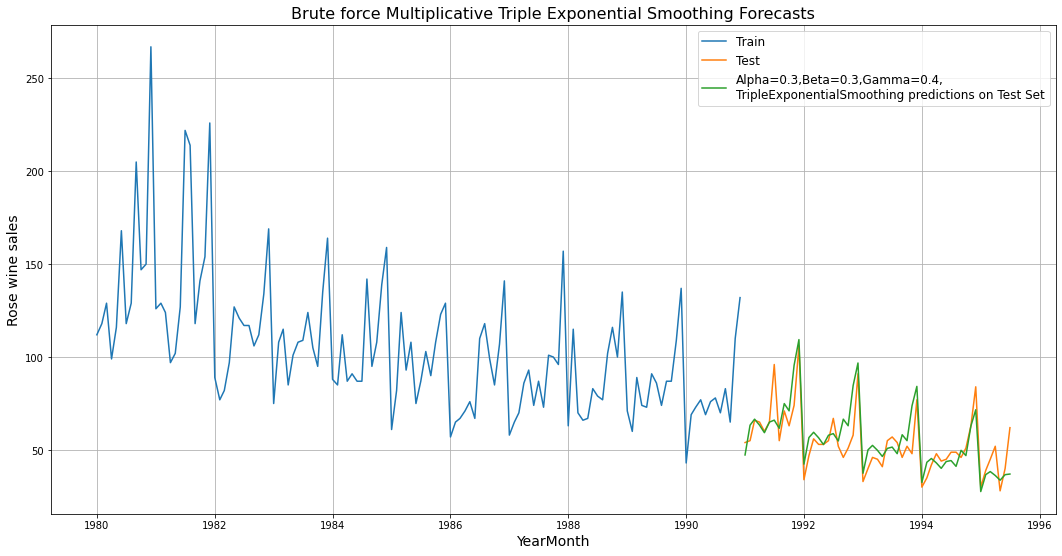

In [848]:
plt.figure(figsize=(18,9))
plt.plot(train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(hw_test['predict', 0.3, 0.3, 0.4], label='Alpha=0.3,Beta=0.3,Gamma=0.4,\nTripleExponentialSmoothing predictions on Test Set')

plt.legend(loc='best', fontsize=12)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose wine sales', fontsize=14)
plt.title('Brute force Multiplicative Triple Exponential Smoothing Forecasts', fontsize=16)
plt.grid();

In [849]:
rmse_model8_test = metrics2.sort_values(by=['Test RMSE']).values[0][4]
print("For Brute forced Triple Exponential multiplicative Smoothing forecast on the Test Data,  RMSE is %3.3f" %(rmse_model8_test))


For Brute forced Triple Exponential multiplicative Smoothing forecast on the Test Data,  RMSE is 10.215


In [850]:
resultsDf_8 = pd.DataFrame({'Test RMSE': [metrics2.sort_values(by=['Test RMSE']).values[0][4]]}
                           ,index=['Brute_force_Triple_Exp_multiplicative_Smoothing_forecast'])

resultsDf = pd.concat([resultsDf, resultsDf_8])
resultsDf

,Test RMSE
LnR_forecast,15.238125
Naive_forecast,79.590941
SimpleAvg_forecast,53.330686
Simple_Exp_Smoothing_forecast,36.665694
Double_Exp_Smoothing_forecast,15.239142
Triple_Exp_additive_Smoothing_forecast,14.186164
Triple_Exp_multiplicative_Smoothing_forecast,19.041869
Brute_force_Triple_Exp_multiplicative_Smoothing_forecast,10.215033


In [851]:
print('Sorted by RMSE values on the Test Data:','\n',)
resultsDf.sort_values(by=['Test RMSE'])

Sorted by RMSE values on the Test Data: 



,Test RMSE
Brute_force_Triple_Exp_multiplicative_Smoothing_forecast,10.215033
Triple_Exp_additive_Smoothing_forecast,14.186164
LnR_forecast,15.238125
Double_Exp_Smoothing_forecast,15.239142
Triple_Exp_multiplicative_Smoothing_forecast,19.041869
Simple_Exp_Smoothing_forecast,36.665694
SimpleAvg_forecast,53.330686
Naive_forecast,79.590941


----

-----

# 1.5) Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment. Note: Stationarity should be checked at alpha = 0.05.

### Step1: Checking for stationarity using Dickey-Fuller Test :

* Null Hypothesis,       H0 : Time Series is non-stationary.
* Alternate Hypothesis,  Ha : Time Series is stationary.

if p-value < 0.05 (alpha value) then null hypothesis: Time series data is non-stationary is rejected, 

if not, then null hypothesis is true i.e. Time series data is indeed non-stationary.

In [852]:
from statsmodels.tsa.stattools import adfuller

In [853]:
dftest = adfuller(df1)
dftest
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is %1.4f' %dftest[1])

DF test statistic is -1.884
DF test p-value is 0.3394


#### the p-value is 0.34 which  is clearly > 0.05, thus Null hypothesis is true. Time series data is not stationary.

### Step2: Making the time series data stationary using the differencing method:

#### Non differenced Time series data:

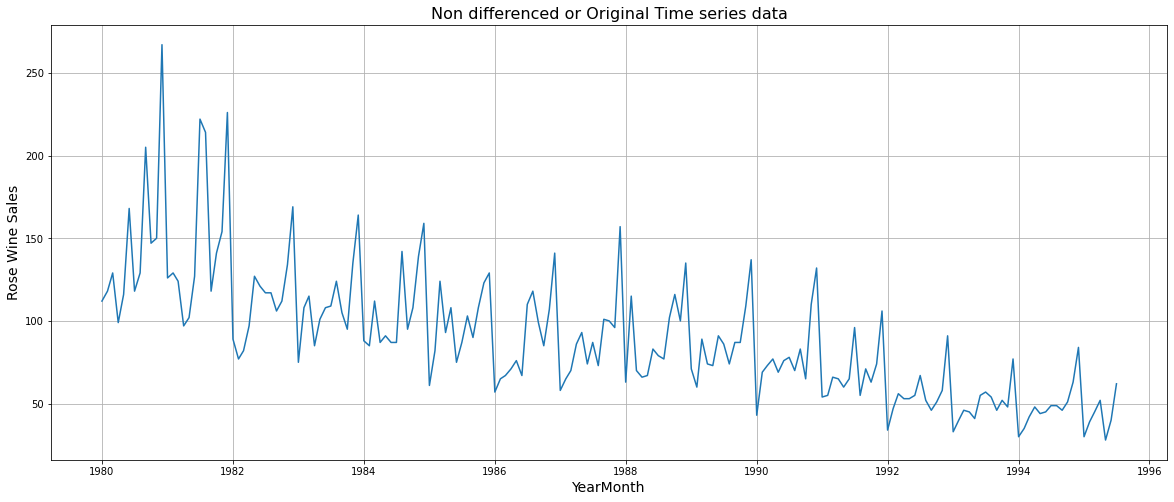

In [854]:
plt.plot(df1)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose Wine Sales',fontsize=14)
plt.title('Non differenced or Original Time series data',fontsize=16)
plt.grid()
plt.show()

#### Performing differencing ( d=1 ) on the non-stationary data:

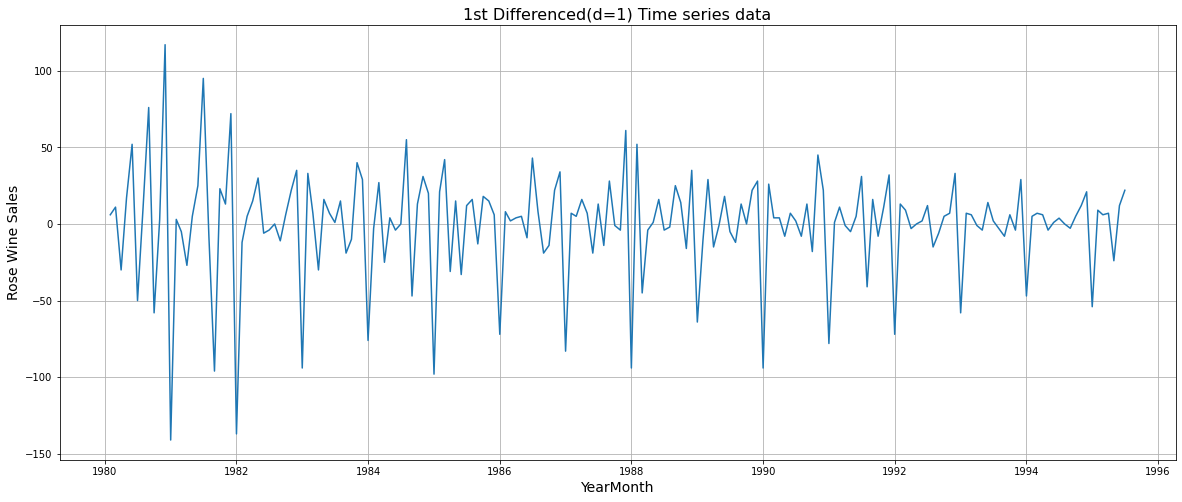

In [855]:
plt.plot(df1.diff(periods=1))
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose Wine Sales',fontsize=14)
plt.title('1st Differenced(d=1) Time series data',fontsize=16)
plt.grid()
plt.show()

#### Checking for stationarity using the Dickey-Fuller test for the differenced(d=1) data:

In [856]:
dftest1 = adfuller(df1.diff(periods=1).dropna())
dftest1
print('DF test1 statistic is %3.3f' %dftest1[0])
print('DF test1 p-value is %1.4f' %dftest1[1])

DF test1 statistic is -8.045
DF test1 p-value is 0.0000


#### the p-value is 0 which  is clearly < 0.05, thus Null hypothesis is rejected i.e. Time series differenced(d=1) data is Stationary.
### Thus we have achieved Stationarity.

-------

-----

# 1.6) Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

In [857]:
train.head()

,Rose
YearMonth,
1980-01-01,112.0
1980-02-01,118.0
1980-03-01,129.0
1980-04-01,99.0
1980-05-01,116.0


In [858]:
print(train.shape)
print(test.shape)

(132, 1)
(55, 1)


### Check for stationarity of the Training Data Time Series.

In [859]:
dftest_train = adfuller(train)
print('DF test statistic is %3.3f' %dftest_train[0])
print('DF test p-value is %1.4f' %dftest_train[1])

DF test statistic is -2.164
DF test p-value is 0.2195


#### the p-value is 0.22 which  is clearly > 0.05, thus Null hypothesis is true. Time series data is not stationary.

#### Making the time series data stationary using the differencing method:

In [860]:
dftest_diff_train = adfuller(train.diff(periods=1).dropna())
print('DF test statistic is %3.3f' %dftest_diff_train[0])
print('DF test p-value is %1.4f' %dftest_diff_train[1])

DF test statistic is -6.592
DF test p-value is 0.0000


#### the p-value is 0 which  is clearly < 0.05, thus Null hypothesis is rejected i.e. Time series differenced(d=1) data is Stationary.
#### Thus we have achieved Stationarity.

---

### Model 9: Build an Automated version of an ARIMA model for which the best parameters are selected in accordance with the lowest Akaike Information Criteria (AIC).

In [861]:
import itertools
p = q = range(0, 3)
d= range(1,2)
pdq = list(itertools.product(p, d, q))
print('Parameter combinations for the Model:')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Parameter combinations for the Model:
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)


In [862]:
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [863]:
from warnings import filterwarnings
filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA

for param in pdq:
    ARIMA_model = ARIMA(train['Rose'].values,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = pd.concat([ARIMA_AIC, pd.DataFrame({'param': [param], 'AIC': [ARIMA_model.aic]})], ignore_index=True)
    
ARIMA_AIC

ARIMA(0, 1, 0) - AIC:1333.1546729124348
ARIMA(0, 1, 1) - AIC:1282.3098319748265
ARIMA(0, 1, 2) - AIC:1279.6715288535784
ARIMA(1, 1, 0) - AIC:1317.3503105381426
ARIMA(1, 1, 1) - AIC:1280.5742295380069
ARIMA(1, 1, 2) - AIC:1279.8707234231906
ARIMA(2, 1, 0) - AIC:1298.6110341604958
ARIMA(2, 1, 1) - AIC:1281.5078621868577
ARIMA(2, 1, 2) - AIC:1281.8707222264197


,param,AIC
0,"(0, 1, 0)",1333.154673
1,"(0, 1, 1)",1282.309832
2,"(0, 1, 2)",1279.671529
3,"(1, 1, 0)",1317.350311
4,"(1, 1, 1)",1280.574230
5,"(1, 1, 2)",1279.870723
6,"(2, 1, 0)",1298.611034
7,"(2, 1, 1)",1281.507862
8,"(2, 1, 2)",1281.870722


#### Sorting the above AIC values in the ascending order to get the parameters for the minimum AIC value.


In [864]:
ARIMA_AIC.sort_values(by='AIC',ascending=True)

,param,AIC
2,"(0, 1, 2)",1279.671529
5,"(1, 1, 2)",1279.870723
4,"(1, 1, 1)",1280.574230
7,"(2, 1, 1)",1281.507862
8,"(2, 1, 2)",1281.870722
1,"(0, 1, 1)",1282.309832
6,"(2, 1, 0)",1298.611034
3,"(1, 1, 0)",1317.350311
0,"(0, 1, 0)",1333.154673


In [865]:
auto_ARIMA = ARIMA(train['Rose'], order=(0,1,2))

results_auto_ARIMA = auto_ARIMA.fit()

print(results_auto_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  132
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -636.836
Date:                Sun, 11 Jun 2023   AIC                           1279.672
Time:                        19:42:00   BIC                           1288.297
Sample:                    01-01-1980   HQIC                          1283.176
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6970      0.072     -9.689      0.000      -0.838      -0.556
ma.L2         -0.2042      0.073     -2.794      0.005      -0.347      -0.061
sigma2       965.8407     88.305     10.938      0.0

#### Forecasting using this model for the duration of the test set


In [866]:
tes_arima_predict =  results_auto_ARIMA.forecast(steps=len(test))
tes_arima_predict.head()

1991-01-01    96.026636
1991-02-01    87.495114
1991-03-01    87.495114
1991-04-01    87.495114
1991-05-01    87.495114
Freq: MS, Name: predicted_mean, dtype: float64

#### Plotting the Training data, Test data and the forecasted values

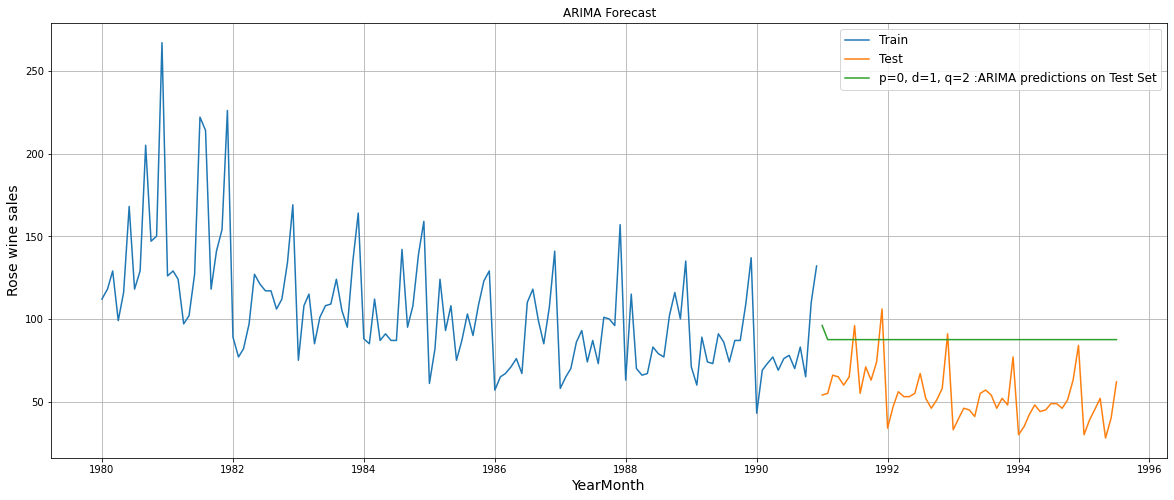

In [867]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')

plt.plot(tes_arima_predict, label='p=0, d=1, q=2 :ARIMA predictions on Test Set')

plt.legend(loc='best', fontsize=12)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose wine sales', fontsize=14)
plt.grid()
plt.title('ARIMA Forecast');

### Model Evaluation

In [868]:
rmse_model9_test = mse(test['Rose'],tes_arima_predict,squared=False)
print("For ARIMA forecast on the Test Data,  RMSE is %3.3f" %(rmse_model9_test))


For ARIMA forecast on the Test Data,  RMSE is 37.176


In [869]:
resultsDf_9 = pd.DataFrame({'Test RMSE': [rmse_model9_test]}
                           ,index=['ARIMA_forecast'])

resultsDf = pd.concat([resultsDf, resultsDf_9])
resultsDf

,Test RMSE
LnR_forecast,15.238125
Naive_forecast,79.590941
SimpleAvg_forecast,53.330686
Simple_Exp_Smoothing_forecast,36.665694
Double_Exp_Smoothing_forecast,15.239142
Triple_Exp_additive_Smoothing_forecast,14.186164
Triple_Exp_multiplicative_Smoothing_forecast,19.041869
Brute_force_Triple_Exp_multiplicative_Smoothing_forecast,10.215033
ARIMA_forecast,37.176466


----

### Model 10: Build an Automated version of a SARIMA model for which the best parameters are selected in accordance with the lowest Akaike Information Criteria (AIC).


#### Setting the seasonality = 12 as evident from the decomposition plot, to estimate parameters using auto SARIMA model.

In [870]:
import itertools
p = q = range(0, 3)
d= range(1,2)
D = range(0,2)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of some parameter combinations for Model...')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], model_pdq[i]))

Examples of some parameter combinations for Model...
Model: (0, 1, 1)(0, 0, 1, 12)
Model: (0, 1, 2)(0, 0, 2, 12)
Model: (1, 1, 0)(0, 1, 0, 12)
Model: (1, 1, 1)(0, 1, 1, 12)
Model: (1, 1, 2)(0, 1, 2, 12)
Model: (2, 1, 0)(1, 0, 0, 12)
Model: (2, 1, 1)(1, 0, 1, 12)
Model: (2, 1, 2)(1, 0, 2, 12)


In [871]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

,param,seasonal,AIC


In [872]:
import statsmodels.api as sm

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train['Rose'].values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = pd.concat([SARIMA_AIC, pd.DataFrame({'param':[param],'seasonal':[param_seasonal] ,'AIC': [results_SARIMA.aic]})], ignore_index=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00750D+00    |proj g|=  3.85985D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   1.652D-07   5.007D+00
  F =   5.0074461648784689     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1323.9657875279158
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.72524D+00    |proj g|=  6.58026D-02

At iterate   10    f=  3.67618D+00    |proj g|=  1.48313D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     21      1     0     0   6.291D-06   3.676D+00
  F =   3.6758997334776087     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 0)x(0, 0, 2, 12) - AIC:976.4375296380887
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43171D+00    |proj g|=  3.26781D-03

           * * 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     14      1     0     0   3.171D-06   3.642D+00
  F =   3.6420671597128589     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:965.5057301641947
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21876D+00    |proj g|=  1.14830D-01

At iterate    5    f=  3.19670D+00    |proj g|=  7.48863D-02

At iterate   10    f=  3.18132D+00    |proj g|=  3.14733D-04

           * * 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.66439D+00    |proj g|=  4.15199D-01

At iterate    5    f=  3.64280D+00    |proj g|=  1.19867D-02

At iterate   10    f=  3.64277D+00    |proj g|=  1.40674D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   6.232D-05   3.643D+00
  F =   3.6427703165736451     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 0)x(1, 0, 2, 12) - AIC:969.6913635754423
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70578D+00    |proj g|=  9.30518D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27090D+00    |proj g|=  2.68866D-01

At iterate    5    f=  3.18639D+00    |proj g|=  1.50526D-02

At iterate   10    f=  3.18239D+00    |proj g|=  1.54408D-02

At iterate   15    f=  3.18081D+00    |proj g|=  2.30843D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   1.371D-07   3.181D+00
  F =   3.1808076449449239     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 0)x(1, 1, 2, 12) - AIC:847.7332182654599
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.22

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


SARIMA(0, 1, 0)x(2, 0, 1, 12) - AIC:962.879454069757
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58992D+00    |proj g|=  1.16506D-01

At iterate    5    f=  3.58185D+00    |proj g|=  3.88612D-03


 This problem is unconstrained.



At iterate   10    f=  3.58182D+00    |proj g|=  3.70028D-03

At iterate   15    f=  3.58172D+00    |proj g|=  4.53052D-03

At iterate   20    f=  3.58172D+00    |proj g|=  1.21859D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   1.219D-05   3.582D+00
  F =   3.5817179579339999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 0)x(2, 0, 2, 12) - AIC:955.573540894576
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


SARIMA(0, 1, 0)x(2, 1, 0, 12) - AIC:858.5132698374405
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23210D+00    |proj g|=  6.01238D-02

At iterate    5    f=  3.20992D+00    |proj g|=  1.39368D-01


 This problem is unconstrained.



At iterate   10    f=  3.20516D+00    |proj g|=  4.06363D-03

At iterate   15    f=  3.20286D+00    |proj g|=  2.57658D-02

At iterate   20    f=  3.20204D+00    |proj g|=  2.68843D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   2.688D-05   3.202D+00
  F =   3.2020419428583873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 0)x(2, 1, 1, 12) - AIC:853.3390729146142
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  3.17118D+00    |proj g|=  2.85622D-02

At iterate   10    f=  3.16763D+00    |proj g|=  2.87544D-02

At iterate   15    f=  3.16624D+00    |proj g|=  3.05615D-02

At iterate   20    f=  3.15450D+00    |proj g|=  3.59207D-02

At iterate   25    f=  3.15390D+00    |proj g|=  5.29175D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     34      1     0     0   2.610D-05   3.154D+00
  F =   3.1538947894793328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 0)x(2, 1, 2, 12) - AIC:842.6282244225439
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.
 This problem is unconstrained.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71952D+00    |proj g|=  1.01503D-01

At iterate    5    f=  3.68220D+00    |proj g|=  1.65258D-02


 This problem is unconstrained.



At iterate   10    f=  3.52809D+00    |proj g|=  8.13702D-01

At iterate   15    f=  3.46833D+00    |proj g|=  2.15994D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   1.160D-05   3.468D+00
  F =   3.4683007762817284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 1)x(0, 0, 2, 12) - AIC:923.6314049383762
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28841D+00    |proj g|=  2.02027D-01

At iterate    5

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.57838D+00    |proj g|=  1.61956D-01

At iterate   15    f=  3.44348D+00    |proj g|=  2.73183D-03
SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:915.0730606717701
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     28      1     0     0   4.214D-07   3.443D+00
  F =   3.4434585631506445     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19734D+00    |proj g|=  7.20713D-02


 This problem is unconstrained.



At iterate    5    f=  3.16899D+00    |proj g|=  2.55424D-02

At iterate   10    f=  3.02768D+00    |proj g|=  3.22745D-01

At iterate   15    f=  2.96556D+00    |proj g|=  9.06635D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   7.209D-06   2.966D+00
  F =   2.9655427307828548     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 1)x(0, 1, 2, 12) - AIC:790.9032809266737
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.96494D+00    |proj g|=  2.45022D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     45      1     0     0   2.552D-05   3.965D+00
  F =   3.9649372465707500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:1054.743433094678
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70606D+00    |proj g|=  1.16728D-01


 This problem is unconstrained.



At iterate    5    f=  3.66794D+00    |proj g|=  1.64727D-02

At iterate   10    f=  3.64073D+00    |proj g|=  5.56530D-02

At iterate   15    f=  3.44794D+00    |proj g|=  8.75421D-02

At iterate   20    f=  3.44271D+00    |proj g|=  7.75855D-03

At iterate   25    f=  3.44264D+00    |proj g|=  2.94505D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     33      1     0     0   2.945D-05   3.443D+00
  F =   3.4426414709472311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 1)x(1, 0, 2, 12) - AIC:918.857348330069
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.55398D+00    |proj g|=  8.45766D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     25      1     0     0   7.683D-05   3.554D+00
  F =   3.5539608543682633     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:944.2456655532214
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64921D+00    |proj g|=  6.67665D-02

At iterate    5    f=  3.62398D+00    |proj g|=  1.71971D-02

At iterate   10

 This problem is unconstrained.


SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:929.3362488520092
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23689D+00    |proj g|=  1.61447D-01

At iterate    5    f=  3.16846D+00    |proj g|=  1.64377D-02

At iterate   10    f=  3.03438D+00    |proj g|=  1.32796D-01

At iterate   15    f=  2.97545D+00    |proj g|=  6.70265D-02

At iterate   20    f=  2.96521D+00    |proj g|=  7.01888D-03

At iterate   25    f=  2.96483D+00    |proj g|=  2.13004D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Pr

 This problem is unconstrained.



At iterate   20    f=  3.43408D+00    |proj g|=  7.97717D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     33      1     0     0   7.977D-06   3.434D+00
  F =   3.4340844191424029     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 1)x(2, 0, 0, 12) - AIC:914.5982866535944
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73874D+00    |proj g|=  7.56750D-02


 This problem is unconstrained.



At iterate    5    f=  3.71583D+00    |proj g|=  6.76122D-02

At iterate   10    f=  3.67889D+00    |proj g|=  2.61238D-01

At iterate   15    f=  3.43852D+00    |proj g|=  1.26595D-01

At iterate   20    f=  3.42934D+00    |proj g|=  1.91672D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     34      1     0     0   5.393D-06   3.429D+00
  F =   3.4292925872960875     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 1)x(2, 0, 1, 12) - AIC:915.3332430461671
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate   10    f=  3.57795D+00    |proj g|=  1.71271D-01

At iterate   15    f=  3.52131D+00    |proj g|=  7.58247D-02

At iterate   20    f=  3.43576D+00    |proj g|=  4.94192D-01

At iterate   25    f=  3.37650D+00    |proj g|=  6.08063D-02

At iterate   30    f=  3.37301D+00    |proj g|=  9.05607D-03

At iterate   35    f=  3.36953D+00    |proj g|=  3.78549D-02

At iterate   40    f=  3.36869D+00    |proj g|=  1.23870D-02

At iterate   45    f=  3.36828D+00    |proj g|=  3.62598D-03

At iterate   50    f=  3.36819D+00    |proj g|=  2.23051D-03

At iterate   55    f=  3.36818D+00    |proj g|=  4.12341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.24342D+00    |proj g|=  7.34306D-02

At iterate   10    f=  3.16289D+00    |proj g|=  3.60646D-01

At iterate   15    f=  3.03911D+00    |proj g|=  9.25639D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   5.433D-07   3.039D+00
  F =   3.0390887689994854     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 1)x(2, 1, 0, 12) - AIC:810.3194350158642
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  3.24231D+00    |proj g|=  6.08495D-02

At iterate   10    f=  3.19602D+00    |proj g|=  5.82032D-02

At iterate   15    f=  3.01549D+00    |proj g|=  1.76037D-01

At iterate   20    f=  3.00818D+00    |proj g|=  6.93918D-03

At iterate   25    f=  3.00817D+00    |proj g|=  1.84095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     47      1     0     0   3.654D-05   3.008D+00
  F =   3.0081650579470409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 1)x(2, 1, 1, 12) - AIC:804.1555752980188
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  3.16764D+00    |proj g|=  1.85942D-02

At iterate   10    f=  3.15613D+00    |proj g|=  4.50867D-02

At iterate   15    f=  3.10832D+00    |proj g|=  1.02703D-01

At iterate   20    f=  3.00205D+00    |proj g|=  2.35311D-01

At iterate   25    f=  2.91980D+00    |proj g|=  6.05120D-02

At iterate   30    f=  2.91730D+00    |proj g|=  1.72768D-02

At iterate   35    f=  2.91725D+00    |proj g|=  5.26974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     46      1     0     0   2.523D-05   2.917D+00
  F =   2.9172495133792080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.12216D+00    |proj g|=  1.42571D-01

At iterate   15    f=  4.07443D+00    |proj g|=  3.76207D-02

At iterate   20    f=  4.07381D+00    |proj g|=  6.22267D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   6.223D-06   4.074D+00
  F =   4.0738132482064060     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 2)x(0, 0, 1, 12) - AIC:1083.4866975264913
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  3.61768D+00    |proj g|=  6.17181D-02

At iterate   10    f=  3.60247D+00    |proj g|=  9.99630D-02

At iterate   15    f=  3.42440D+00    |proj g|=  5.15437D-02

At iterate   20    f=  3.42233D+00    |proj g|=  3.22711D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   2.091D-06   3.422D+00
  F =   3.4223251843248881     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 2)x(0, 0, 2, 12) - AIC:913.4938486617705
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.45258D+00    |proj g|=  1.45980D-02

At iterate   10    f=  3.41501D+00    |proj g|=  9.65760D-02

At iterate   15    f=  3.39583D+00    |proj g|=  1.42411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   2.630D-06   3.396D+00
  F =   3.3958346547246210     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 2)x(0, 1, 1, 12) - AIC:904.5003488473
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0   

 This problem is unconstrained.



At iterate   15    f=  4.09623D+00    |proj g|=  1.00394D-01

At iterate   20    f=  4.09407D+00    |proj g|=  3.07000D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   1.363D-05   4.094D+00
  F =   4.0940654709899178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 2)x(1, 0, 0, 12) - AIC:1088.8332843413384
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08453D+00    |proj g|=  8.01604D-02

At iterate    

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     38      1     0     0   6.718D-05   3.923D+00
  F =   3.9225003536021013     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 2)x(1, 0, 1, 12) - AIC:1045.5400933509547
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62467D+00    |proj g|=  1.21016D-01


 This problem is unconstrained.



At iterate    5    f=  3.59567D+00    |proj g|=  1.70714D-02

At iterate   10    f=  3.58784D+00    |proj g|=  1.99114D-02

At iterate   15    f=  3.50486D+00    |proj g|=  2.08492D-01

At iterate   20    f=  3.39380D+00    |proj g|=  1.08431D-01

At iterate   25    f=  3.38194D+00    |proj g|=  5.13679D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     34      1     0     0   8.096D-05   3.382D+00
  F =   3.3819359521097114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 2)x(1, 0, 2, 12) - AIC:904.8310913569638
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  3.57670D+00    |proj g|=  1.29389D-02

At iterate   10    f=  3.55908D+00    |proj g|=  8.70947D-02

At iterate   15    f=  3.53608D+00    |proj g|=  2.64398D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   9.985D-06   3.536D+00
  F =   3.5360821679404477     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 2)x(1, 1, 0, 12) - AIC:941.5256923362782
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   1.467D-05   3.429D+00
  F =   3.4290648235191816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 2)x(1, 1, 1, 12) - AIC:915.273113409064
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09741D+00    |proj g|=  2.72321D-01

At iterate    5    f=  3.02024D+00    |proj g|=  5.05310D-02

At iterate   10    f=  3.00463D+00    |proj g|=  5.55793D-02

At iterate   15 

 This problem is unconstrained.



At iterate   20    f=  3.42049D+00    |proj g|=  1.56950D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     29      1     0     0   1.570D-06   3.420D+00
  F =   3.4204946637340834     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 2)x(2, 0, 0, 12) - AIC:913.0105912257981
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69475D+00    |proj g|=  6.55364D-02

At iterate    5    f=  3.67886D+00    |proj g|=  1.95074D-02

At iterate   10

 This problem is unconstrained.



At iterate   25    f=  3.41731D+00    |proj g|=  1.36338D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     35      1     0     0   2.438D-05   3.417D+00
  F =   3.4173134640321039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 2)x(2, 0, 1, 12) - AIC:914.1707545044754
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60284D+00    |proj g|=  1.03104D-01

At iterate    5    f=  3.57509D+00    |proj g|=  1.81151D-02

At iterate   10

 This problem is unconstrained.



At iterate   15    f=  3.38907D+00    |proj g|=  2.56646D-01

At iterate   20    f=  3.31168D+00    |proj g|=  6.30335D-02

At iterate   25    f=  3.31037D+00    |proj g|=  5.68989D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     34      1     0     0   2.339D-05   3.310D+00
  F =   3.3103693506366336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:887.9375085680713
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  3.12019D+00    |proj g|=  1.69009D-02

At iterate   10    f=  3.08590D+00    |proj g|=  2.51982D-01

At iterate   15    f=  3.03636D+00    |proj g|=  1.29935D-02

At iterate   20    f=  3.03617D+00    |proj g|=  1.99257D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   1.529D-05   3.036D+00
  F =   3.0361702417342169     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 2)x(2, 1, 0, 12) - AIC:811.5489438178332
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate   10    f=  3.10548D+00    |proj g|=  7.84967D-02

At iterate   15    f=  3.08954D+00    |proj g|=  1.01362D-01

At iterate   20    f=  3.01761D+00    |proj g|=  8.74688D-01

At iterate   25    f=  3.00524D+00    |proj g|=  5.54876D-02

At iterate   30    f=  3.00423D+00    |proj g|=  9.28844D-03

At iterate   35    f=  3.00423D+00    |proj g|=  1.64886D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     52      1     0     0   1.649D-06   3.004D+00
  F =   3.0042267002763179     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 2)x(2, 1, 1, 12) - AIC:805.11584887294

 This problem is unconstrained.



At iterate    5    f=  3.00799D+00    |proj g|=  3.02750D-02

At iterate   10    f=  3.00011D+00    |proj g|=  3.32657D-02

At iterate   15    f=  2.97214D+00    |proj g|=  5.41485D-02

At iterate   20    f=  2.91172D+00    |proj g|=  1.28214D-01

At iterate   25    f=  2.88259D+00    |proj g|=  5.75759D-03

At iterate   30    f=  2.88253D+00    |proj g|=  1.55904D-02

At iterate   35    f=  2.88246D+00    |proj g|=  7.83590D-04

At iterate   40    f=  2.88246D+00    |proj g|=  6.11545D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     54      1     0     0   1.272D-05   2.882D+00
  F =   2.88245878610

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.77292D+00    |proj g|=  8.11557D-02

At iterate   10    f=  3.62988D+00    |proj g|=  9.09667D-02

At iterate   15    f=  3.62099D+00    |proj g|=  1.44028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   1.946D-06   3.621D+00
  F =   3.6209868906279108     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:963.9405391257684
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27508D+00    |proj g|=  5.43463D-02

At iterate    5    f=  3.23066D+00    |proj g|=  1.35141D-01

At iterate   10    f=  3.11048D+00    |proj g|=  3.84419D-02

At iterate   15    f=  3.10924D+00    |proj g|=  1.22153D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   4.078D-07   3.109D+00
  F =   3.1092419821292534     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78617D+00    |proj g|=  1.13508D-01

At iterate    5    f=  3.76165D+00    |proj g|=  1.45440D-02

At iterate   10    f=  3.68476D+00    |proj g|=  1.91002D-01

At iterate   15    f=  3.59281D+00    |proj g|=  4.46715D-03

At iterate   20    f=  3.59280D+00    |proj g|=  1.23643D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   1.236D-06   3.593D+00
  F =   3.5928037776318638     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.23645D+00    |proj g|=  7.83390D-02

At iterate   10    f=  3.11732D+00    |proj g|=  1.16146D-01

At iterate   15    f=  3.10723D+00    |proj g|=  1.02465D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   3.410D-06   3.107D+00
  F =   3.1072256836996761     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 0)x(1, 1, 2, 12) - AIC:830.3075804967145
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate   10    f=  3.52907D+00    |proj g|=  1.62721D-02

At iterate   15    f=  3.52689D+00    |proj g|=  2.56642D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   8.075D-06   3.527D+00
  F =   3.5268881737363880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 0)x(2, 0, 0, 12) - AIC:939.0984778664064
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74998D+00    |proj g|=  7.71543D-02

At iterate    5

 This problem is unconstrained.



At iterate   15    f=  3.52621D+00    |proj g|=  6.80092D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   9.273D-06   3.526D+00
  F =   3.5261693688110101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 0)x(2, 0, 1, 12) - AIC:940.9087133661067
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76230D+00    |proj g|=  9.71941D-02


 This problem is unconstrained.



At iterate    5    f=  3.73927D+00    |proj g|=  1.74720D-02

At iterate   10    f=  3.67792D+00    |proj g|=  2.08147D-01

At iterate   15    f=  3.52599D+00    |proj g|=  2.64537D-02

At iterate   20    f=  3.52385D+00    |proj g|=  1.99502D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     23      1     0     0   2.988D-05   3.524D+00
  F =   3.5238534481329449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 0)x(2, 0, 2, 12) - AIC:942.2973103070974
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.


SARIMA(1, 1, 0)x(2, 1, 0, 12) - AIC:826.9995808091082
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26800D+00    |proj g|=  5.83065D-02

At iterate    5    f=  3.23107D+00    |proj g|=  2.57850D-01


 This problem is unconstrained.



At iterate   10    f=  3.09157D+00    |proj g|=  9.78358D-02

At iterate   15    f=  3.08268D+00    |proj g|=  4.62091D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     30      1     0     0   1.043D-05   3.083D+00
  F =   3.0826746601498773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 0)x(2, 1, 1, 12) - AIC:823.8261102795676
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30984D+00    |proj g|=  1.57948D-01


 This problem is unconstrained.



At iterate    5    f=  3.25797D+00    |proj g|=  1.46467D-02

At iterate   10    f=  3.23548D+00    |proj g|=  4.72659D-02

At iterate   15    f=  3.17010D+00    |proj g|=  1.40249D+00

At iterate   20    f=  3.08349D+00    |proj g|=  8.58984D-02

At iterate   25    f=  3.07990D+00    |proj g|=  1.89804D-02

At iterate   30    f=  3.07971D+00    |proj g|=  1.08836D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     38      1     0     0   2.516D-05   3.080D+00
  F =   3.0797110807129418     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 0)x(2, 1, 2, 12) - AIC:825.04372530821

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.11484D+00    |proj g|=  5.56712D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   9.273D-06   4.115D+00
  F =   4.1148381472123940     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:1094.317270864072
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70733D+00    |proj g|=  9.69437D-02


 This problem is unconstrained.



At iterate    5    f=  3.67921D+00    |proj g|=  1.63520D-02

At iterate   10    f=  3.64967D+00    |proj g|=  8.48310D-02

At iterate   15    f=  3.46782D+00    |proj g|=  7.54150D-02

At iterate   20    f=  3.45866D+00    |proj g|=  1.20865D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     29      1     0     0   9.465D-06   3.459D+00
  F =   3.4586599333575334     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 1)x(0, 0, 2, 12) - AIC:923.0862224063889
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.59002D+00    |proj g|=  1.69428D-02

At iterate   10    f=  3.46163D+00    |proj g|=  2.36495D-01

At iterate   15    f=  3.43201D+00    |proj g|=  4.34469D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   4.338D-07   3.432D+00
  F =   3.4319900927985696     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:914.0453844988224


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17320D+00    |proj g|=  7.35412D-02

At iterate    5    f=  3.15223D+00    |proj g|=  1.65393D-02

At iterate   10    f=  3.07878D+00    |proj g|=  7.06361D-02

At iterate   15    f=  2.98563D+00    |proj g|=  1.49359D-01

At iterate   20    f=  2.96341D+00    |proj g|=  2.00919D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     35      1     0     0   6.908D-07   2.963D+00
  F =   2.9634133980517650     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.18948D+00    |proj g|=  2.64416D-02

At iterate   10    f=  4.18448D+00    |proj g|=  9.13561D-02

At iterate   15    f=  4.08297D+00    |proj g|=  1.54258D-01

At iterate   20    f=  4.07346D+00    |proj g|=  9.53499D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   1.405D-05   4.073D+00
  F =   4.0734613503915034     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:1083.393796503357
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.



At iterate   15    f=  3.42854D+00    |proj g|=  5.35344D-02

At iterate   20    f=  3.42564D+00    |proj g|=  1.30572D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     27      1     0     0   5.105D-05   3.426D+00
  F =   3.4255869047370360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(1, 0, 2, 12) - AIC:916.3549428505775
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64887D+00    |proj g|=  6.77368D-02

At iterate    5

 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:933.2974216823709
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61557D+00    |proj g|=  6.72325D-02

At iterate    5    f=  3.60489D+00    |proj g|=  1.58529D-02

At iterate   10    f=  3.48294D+00    |proj g|=  7.71312D-02

At iterate   15    f=  3.47459D+00    |proj g|=  3.80576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   1.513D-05   3.475D+00
  F =   3.4745911508334975     

CONVERGENCE: RE

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21085D+00    |proj g|=  1.51120D-01

At iterate    5    f=  3.15389D+00    |proj g|=  1.65338D-02

At iterate   10    f=  3.10269D+00    |proj g|=  7.79048D-02

At iterate   15    f=  2.96536D+00    |proj g|=  5.96948D-02

At iterate   20    f=  2.96285D+00    |proj g|=  4.44753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     26      1     0     0   2.151D-06   2.963D+00
  F =   2.9628521616224703     

CONVERG

 This problem is unconstrained.



At iterate   15    f=  3.39429D+00    |proj g|=  6.99131D-02

At iterate   20    f=  3.39365D+00    |proj g|=  1.91669D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     35      1     0     0   6.186D-06   3.394D+00
  F =   3.3936549472892890     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 1)x(2, 0, 0, 12) - AIC:905.9249060843723
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69196D+00    |proj g|=  6.07566D-02

At iterate    5

 This problem is unconstrained.



At iterate   10    f=  3.51896D+00    |proj g|=  4.77566D-01

At iterate   15    f=  3.39174D+00    |proj g|=  3.66169D-02

At iterate   20    f=  3.39128D+00    |proj g|=  3.00099D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     27      1     0     0   2.103D-05   3.391D+00
  F =   3.3912776013146964     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(2, 0, 1, 12) - AIC:907.2972867470799
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  3.63833D+00    |proj g|=  1.77384D-02

At iterate   10    f=  3.61820D+00    |proj g|=  5.04973D-02

At iterate   15    f=  3.42463D+00    |proj g|=  8.01993D-02

At iterate   20    f=  3.35867D+00    |proj g|=  7.79004D-03

At iterate   25    f=  3.35861D+00    |proj g|=  7.83314D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     35      1     0     0   1.355D-06   3.359D+00
  F =   3.3586082560366899     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 1)x(2, 0, 2, 12) - AIC:900.6725795936861
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate   15    f=  2.99223D+00    |proj g|=  1.06928D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   2.917D-05   2.992D+00
  F =   2.9922250978492202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(2, 1, 0, 12) - AIC:799.9474258321941
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20525D+00    |proj g|=  6.71132D-02

At iterate    5    f=  3.18737D+00    |proj g|=  1.85811D-02


 This problem is unconstrained.



At iterate   10    f=  3.16380D+00    |proj g|=  4.67608D-02

At iterate   15    f=  3.10699D+00    |proj g|=  3.02060D-01

At iterate   20    f=  2.95634D+00    |proj g|=  6.12767D-02

At iterate   25    f=  2.95420D+00    |proj g|=  4.41758D-03

At iterate   30    f=  2.95419D+00    |proj g|=  3.01970D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     41      1     0     0   3.020D-05   2.954D+00
  F =   2.9541914531612203     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(2, 1, 1, 12) - AIC:791.9065436345621


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21039D+00    |proj g|=  1.53049D-01

At iterate    5    f=  3.15328D+00    |proj g|=  1.68931D-02

At iterate   10    f=  3.14674D+00    |proj g|=  3.75430D-02

At iterate   15    f=  3.10923D+00    |proj g|=  5.35173D-02

At iterate   20    f=  2.95453D+00    |proj g|=  1.61819D-01

At iterate   25    f=  2.91719D+00    |proj g|=  1.18492D-01

At iterate   30    f=  2.91630D+00    |proj g|=  4.21128D-03

At iterate   35    f=  2.91628D+00    |proj g|=  1.51248D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  4.07384D+00    |proj g|=  6.03283D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   6.360D-06   4.074D+00
  F =   4.0738113364018522     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 2)x(0, 0, 1, 12) - AIC:1085.486192810089
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64290D+00    |proj g|=  1.06441D-01


 This problem is unconstrained.



At iterate    5    f=  3.61078D+00    |proj g|=  1.61557D-02

At iterate   10    f=  3.52058D+00    |proj g|=  2.77619D-01

At iterate   15    f=  3.49551D+00    |proj g|=  1.12933D-01

At iterate   20    f=  3.46716D+00    |proj g|=  2.64059D+00

At iterate   25    f=  3.43013D+00    |proj g|=  6.17321D-02

At iterate   30    f=  3.42238D+00    |proj g|=  3.23817D-02

At iterate   35    f=  3.42233D+00    |proj g|=  1.54798D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     47      1     0     0   1.548D-05   3.422D+00
  F =   3.4223251523700648     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.




At iterate   20    f=  4.12260D+00    |proj g|=  6.12724D-03

At iterate   25    f=  4.12257D+00    |proj g|=  7.53182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     41      1     0     0   8.227D-06   4.123D+00
  F =   4.1225647821592091     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46488D+00    |proj g|=  9.22148D-02

At iterate    5    f=  3.45139D+00    |proj g|=  2.04746D-02

At ite

 This problem is unconstrained.



At iterate    5    f=  3.00986D+00    |proj g|=  3.24194D-02

At iterate   10    f=  2.93334D+00    |proj g|=  5.52182D-02

At iterate   15    f=  2.93187D+00    |proj g|=  1.52469D-03

At iterate   20    f=  2.93176D+00    |proj g|=  3.16948D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     29      1     0     0   2.035D-04   2.932D+00
  F =   2.9317548253387060     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 2)x(0, 1, 2, 12) - AIC:785.9832738894183
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.



At iterate   35    f=  4.09415D+00    |proj g|=  9.83411D-02

At iterate   40    f=  4.09386D+00    |proj g|=  2.40661D-02

At iterate   45    f=  4.09385D+00    |proj g|=  5.85654D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     70      1     0     0   5.608D-05   4.094D+00
  F =   4.0938488322728483     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 2)x(1, 0, 0, 12) - AIC:1090.776091720032
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate   45    f=  3.90386D+00    |proj g|=  2.94555D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     78      1     0     0   2.338D-05   3.904D+00
  F =   3.9038572771787146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 2)x(1, 0, 1, 12) - AIC:1042.6183211751807
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62235D+00    |proj g|=  1.25133D-01

At iterate    5    f=  3.58726D+00    |proj g|=  1.71022D-02


 This problem is unconstrained.



At iterate   10    f=  3.52802D+00    |proj g|=  1.87541D-01

At iterate   15    f=  3.44358D+00    |proj g|=  6.57941D-02

At iterate   20    f=  3.43206D+00    |proj g|=  1.79679D-01

At iterate   25    f=  3.42434D+00    |proj g|=  2.43720D-01

At iterate   30    f=  3.42147D+00    |proj g|=  1.21746D-01

At iterate   35    f=  3.41981D+00    |proj g|=  4.00550D-02

At iterate   40    f=  3.40431D+00    |proj g|=  2.29308D-01

At iterate   45    f=  3.38832D+00    |proj g|=  1.52942D-01

At iterate   50    f=  3.38158D+00    |proj g|=  5.19294D-03
SARIMA(1, 1, 2)x(1, 0, 2, 12) - AIC:906.7318500405232
At iterate   55    f=  3.38156D+00    |proj g|=  6.12896D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   4.098D-05   3.503D+00
  F =   3.5033599971356173     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 2)x(1, 1, 0, 12) - AIC:934.887039243803
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48071D+00    |proj g|=  9.32931D-02

At iterate    5    f=  3.46904D+00    |proj g|=  1.69924D-02

At iterate   10    f=  3.44659D+00    |proj g|=  1.76264D-01


 This problem is unconstrained.



At iterate   15    f=  3.44214D+00    |proj g|=  1.05504D-02

At iterate   20    f=  3.43244D+00    |proj g|=  8.60727D-02

At iterate   25    f=  3.42899D+00    |proj g|=  1.55541D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     36      1     0     0   2.065D-06   3.429D+00
  F =   3.4289878100047346     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 2)x(1, 1, 1, 12) - AIC:917.2527818412499
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  3.01458D+00    |proj g|=  1.55281D-02

At iterate   10    f=  2.96003D+00    |proj g|=  2.20187D-01

At iterate   15    f=  2.93143D+00    |proj g|=  3.32832D-03

At iterate   20    f=  2.93130D+00    |proj g|=  1.07238D-02

At iterate   25    f=  2.93100D+00    |proj g|=  1.09290D-03

At iterate   30    f=  2.93100D+00    |proj g|=  3.12357D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     35      1     0     0   1.691D-05   2.931D+00
  F =   2.9310015038741746     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 2)x(1, 1, 2, 12) - AIC:787.78439702278

 This problem is unconstrained.



At iterate   15    f=  3.48275D+00    |proj g|=  1.56172D-01

At iterate   20    f=  3.48131D+00    |proj g|=  3.19721D-01

At iterate   25    f=  3.44267D+00    |proj g|=  2.43021D-01

At iterate   30    f=  3.40139D+00    |proj g|=  1.40424D-01

At iterate   35    f=  3.38753D+00    |proj g|=  3.01333D-02

At iterate   40    f=  3.38702D+00    |proj g|=  8.66964D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     73      1     0     0   2.548D-06   3.387D+00
  F =   3.3870038624305514     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 2)x(2, 0, 0, 12) - AIC:906.16901968166

 This problem is unconstrained.



At iterate    5    f=  3.63581D+00    |proj g|=  1.83514D-02

At iterate   10    f=  3.57904D+00    |proj g|=  2.11260D-01

At iterate   15    f=  3.45331D+00    |proj g|=  1.55272D-01

At iterate   20    f=  3.42940D+00    |proj g|=  7.49153D-01

At iterate   25    f=  3.42855D+00    |proj g|=  7.36383D-02

At iterate   30    f=  3.42270D+00    |proj g|=  6.10764D-01

At iterate   35    f=  3.39588D+00    |proj g|=  3.83219D-02

At iterate   40    f=  3.38552D+00    |proj g|=  6.24611D-02

At iterate   45    f=  3.38432D+00    |proj g|=  7.01739D-04

At iterate   50    f=  3.38432D+00    |proj g|=  2.44842D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59899D+00    |proj g|=  1.03167D-01

At iterate    5    f=  3.56578D+00    |proj g|=  1.94295D-02

At iterate   10    f=  3.49004D+00    |proj g|=  1.27647D-01

At iterate   15    f=  3.41630D+00    |proj g|=  1.16820D-01

At iterate   20    f=  3.36881D+00    |proj g|=  2.63625D+00

At iterate   25    f=  3.36597D+00    |proj g|=  7.09693D-02

At iterate   30    f=  3.36284D+00    |proj g|=  9.71299D-01

At iterate   35    f=  3.36047D+00    |proj g|=  3.48356D-01

At iterate   40    f=  3.34932D+00    |proj g|=  8.66849D-01

At iterate   45    f=  3.34688D+00    |proj g|=  2.80715D-01

At iterate   50    f=  3.34550D+00    |proj g|=  9.31038D-01

At iterate   55    f=  3.33952D+00    |proj g|=  1.29964D-01

At iterate   60    f=  3.33627D+00    |proj g|=  1.12366D-01

At iterate   65    f=  3.3

 This problem is unconstrained.



At iterate    5    f=  3.07798D+00    |proj g|=  3.94619D-02

At iterate   10    f=  2.99500D+00    |proj g|=  5.26341D-02

At iterate   15    f=  2.99320D+00    |proj g|=  2.25072D-03

At iterate   20    f=  2.99242D+00    |proj g|=  7.33142D-03

At iterate   25    f=  2.99219D+00    |proj g|=  1.15729D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     32      1     0     0   1.582D-05   2.992D+00
  F =   2.9921901712663397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 2)x(2, 1, 0, 12) - AIC:801.9382052143137
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate   10    f=  3.06528D+00    |proj g|=  1.75640D-02

At iterate   15    f=  3.00830D+00    |proj g|=  2.47815D-01

At iterate   20    f=  2.95453D+00    |proj g|=  1.69404D-02

At iterate   25    f=  2.95395D+00    |proj g|=  3.41189D-04

At iterate   30    f=  2.95394D+00    |proj g|=  4.12911D-03

At iterate   35    f=  2.95292D+00    |proj g|=  1.01575D-01

At iterate   40    f=  2.94736D+00    |proj g|=  5.90847D-02

At iterate   45    f=  2.94677D+00    |proj g|=  5.91414D-03

At iterate   50    f=  2.94666D+00    |proj g|=  9.83694D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     53     70   

 This problem is unconstrained.



At iterate    5    f=  3.01079D+00    |proj g|=  5.16718D-02

At iterate   10    f=  2.99856D+00    |proj g|=  2.61314D-02

At iterate   15    f=  2.98671D+00    |proj g|=  4.48282D-02

At iterate   20    f=  2.89632D+00    |proj g|=  1.25479D-01

At iterate   25    f=  2.88250D+00    |proj g|=  8.71837D-03

At iterate   30    f=  2.88249D+00    |proj g|=  1.34325D-04

At iterate   35    f=  2.88249D+00    |proj g|=  2.08937D-03

At iterate   40    f=  2.88237D+00    |proj g|=  7.72520D-03

At iterate   45    f=  2.88235D+00    |proj g|=  9.19555D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     58   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75501D+00    |proj g|=  1.01527D-01

At iterate    5    f=  3.72757D+00    |proj g|=  5.50269D-02

At iterate   10    f=  3.59598D+00    |proj g|=  2.20123D-02

At iterate   15    f=  3.59121D+00    |proj g|=  1.80633D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   4.213D-06   3.591D+00
  F =   3.5912095487992262     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2

 This problem is unconstrained.



At iterate    5    f=  3.20481D+00    |proj g|=  4.38076D-02

At iterate   10    f=  3.09952D+00    |proj g|=  6.98213D-02

At iterate   15    f=  3.09543D+00    |proj g|=  2.80412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   8.363D-06   3.095D+00
  F =   3.0954293132964605     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 0)x(0, 1, 2, 12) - AIC:827.1933387102656
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  4.04086D+00    |proj g|=  6.23133D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   8.007D-06   4.041D+00
  F =   4.0408572722125333     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 0)x(1, 0, 1, 12) - AIC:1076.7863198641087
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73982D+00    |proj g|=  1.28107D-01

At iterate    5    f=  3.70863D+00    |proj g|=  1.52043D-02


 This problem is unconstrained.



At iterate   10    f=  3.61511D+00    |proj g|=  2.30314D-01

At iterate   15    f=  3.55760D+00    |proj g|=  6.38282D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     23      1     0     0   1.253D-05   3.558D+00
  F =   3.5575712748330077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 0)x(1, 0, 2, 12) - AIC:951.198816555914
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65067D+00    |proj g|=  9.63491D-02

At iterate    5 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.63593D+00    |proj g|=  2.26629D-02

At iterate   10    f=  3.57081D+00    |proj g|=  5.03425D-02

At iterate   15    f=  3.56918D+00    |proj g|=  5.17018D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   5.170D-06   3.569D+00
  F =   3.5691755753360139     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 0)x(1, 1, 1, 12) - AIC:952.2623518887077
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  3.20886D+00    |proj g|=  2.32082D-02

At iterate   10    f=  3.16225D+00    |proj g|=  1.66708D-01

At iterate   15    f=  3.10256D+00    |proj g|=  6.30684D-02

At iterate   20    f=  3.09427D+00    |proj g|=  6.69208D-03

At iterate   25    f=  3.09365D+00    |proj g|=  1.20342D-03

At iterate   30    f=  3.09364D+00    |proj g|=  2.50413D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     36      1     0     0   2.476D-06   3.094D+00
  F =   3.0936358716456409     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 0)x(1, 1, 2, 12) - AIC:828.71987011444

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.64876D+00    |proj g|=  1.85650D-02

At iterate   10    f=  3.50157D+00    |proj g|=  2.23491D-01

At iterate   15    f=  3.46205D+00    |proj g|=  5.73071D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     22      1     0     0   4.177D-05   3.462D+00
  F =   3.4620294702210801     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 0)x(2, 0, 1, 12) - AIC:925.9757801383652
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate   20    f=  3.46151D+00    |proj g|=  1.57554D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     28      1     0     0   1.318D-06   3.462D+00
  F =   3.4615078383639366     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 0)x(2, 0, 2, 12) - AIC:927.8380693280793
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19314D+00    |proj g|=  1.03018D-01

At iterate    5    f=  3.12346D+00    |proj g|=  1.59267D-01

At iterate   10

 This problem is unconstrained.


SARIMA(2, 1, 0)x(2, 1, 0, 12) - AIC:814.2969261795361
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19485D+00    |proj g|=  1.05665D-01

At iterate    5    f=  3.16825D+00    |proj g|=  3.04431D-02


 This problem is unconstrained.



At iterate   10    f=  3.15699D+00    |proj g|=  2.11842D-02

At iterate   15    f=  3.07163D+00    |proj g|=  1.66972D-01

At iterate   20    f=  3.01924D+00    |proj g|=  1.64145D-02

At iterate   25    f=  3.01772D+00    |proj g|=  5.11317D-02

At iterate   30    f=  3.01708D+00    |proj g|=  1.08538D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     44      1     0     0   4.363D-05   3.017D+00
  F =   3.0170836798935179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 0)x(2, 1, 1, 12) - AIC:808.5100914918887
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate   10    f=  3.15308D+00    |proj g|=  2.65976D-02

At iterate   15    f=  3.12048D+00    |proj g|=  1.14237D-01

At iterate   20    f=  3.01616D+00    |proj g|=  8.97311D-02

At iterate   25    f=  3.01520D+00    |proj g|=  3.52112D-03

At iterate   30    f=  3.01518D+00    |proj g|=  3.17506D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     40      1     0     0   3.175D-05   3.015D+00
  F =   3.0151798500676006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 0)x(2, 1, 2, 12) - AIC:810.0074804178465
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.17918D+00    |proj g|=  5.27962D-02

At iterate   10    f=  4.17606D+00    |proj g|=  4.58766D-02

At iterate   15    f=  4.11520D+00    |proj g|=  1.83292D-01

At iterate   20    f=  4.10685D+00    |proj g|=  3.45904D-04
SARIMA(2, 1, 1)x(0, 0, 1, 12) - AIC:1094.2093491949406
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   5.956D-06   4.107D+00
  F =   4.1068535954353811     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  3.66388D+00    |proj g|=  5.51283D-02

At iterate   10    f=  3.65229D+00    |proj g|=  3.38102D-02

At iterate   15    f=  3.51641D+00    |proj g|=  2.23302D-01

At iterate   20    f=  3.45077D+00    |proj g|=  4.84224D-02

At iterate   25    f=  3.45053D+00    |proj g|=  3.65287D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     45      1     0     0   8.759D-06   3.451D+00
  F =   3.4505335121479712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 1)x(0, 0, 2, 12) - AIC:922.9408472070644
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.16336D+00    |proj g|=  6.37756D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   1.665D-06   4.163D+00
  F =   4.1633205918026794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 1)x(0, 1, 0, 12) - AIC:1107.1166362359074
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59419D+00    |proj g|=  8.70536D-02

At iterate    5    f=  3.56709D+00    |proj g|=  2.06818D-02

At iterate   1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16476D+00    |proj g|=  8.69261D-02

At iterate    5    f=  3.13078D+00    |proj g|=  2.53797D-02

At iterate   10    f=  3.04869D+00    |proj g|=  1.72779D-01

At iterate   15    f=  2.96319D+00    |proj g|=  3.63184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     24      1     0     0   2.302D-05   2.963D+00
  F =   2.9631816766203065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2

 This problem is unconstrained.



At iterate   20    f=  4.02055D+00    |proj g|=  2.96957D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     31      1     0     0   9.160D-06   4.021D+00
  F =   4.0205490913262487     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 1)x(1, 0, 0, 12) - AIC:1071.4249601101296
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14255D+00    |proj g|=  6.82047D-02

At iterate    5    f=  4.11396D+00    |proj g|=  3.19747D-02

At iterate   1

 This problem is unconstrained.



At iterate   30    f=  3.94290D+00    |proj g|=  2.17844D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     37      1     0     0   2.178D-05   3.943D+00
  F =   3.9428956330312626     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 1)x(1, 0, 1, 12) - AIC:1052.9244471202533
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68932D+00    |proj g|=  1.21749D-01


 This problem is unconstrained.



At iterate    5    f=  3.64556D+00    |proj g|=  2.69003D-02

At iterate   10    f=  3.63460D+00    |proj g|=  4.54313D-02

At iterate   15    f=  3.50457D+00    |proj g|=  2.79886D-01

At iterate   20    f=  3.42757D+00    |proj g|=  5.49493D-02

At iterate   25    f=  3.41759D+00    |proj g|=  1.81910D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     38      1     0     0   2.428D-05   3.418D+00
  F =   3.4175851942509810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 1)x(1, 0, 2, 12) - AIC:916.2424912822589
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.58204D+00    |proj g|=  1.95296D-02

At iterate   10    f=  3.51214D+00    |proj g|=  1.45761D-01

At iterate   15    f=  3.47091D+00    |proj g|=  3.16088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   2.114D-06   3.471D+00
  F =   3.4709079682834094     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 1)x(1, 1, 0, 12) - AIC:926.3197036268201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate   10    f=  3.08562D+00    |proj g|=  7.30778D-02

At iterate   15    f=  2.96955D+00    |proj g|=  1.86175D-01

At iterate   20    f=  2.96265D+00    |proj g|=  4.90960D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     27      1     0     0   1.281D-05   2.963D+00
  F =   2.9626136368906937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 1)x(1, 1, 2, 12) - AIC:796.1300001391431
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate   15    f=  3.37700D+00    |proj g|=  7.91190D-02

At iterate   20    f=  3.35057D+00    |proj g|=  2.97118D-02

At iterate   25    f=  3.35045D+00    |proj g|=  9.40682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     32      1     0     0   2.257D-05   3.350D+00
  F =   3.3504475788065520     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 1)x(2, 0, 0, 12) - AIC:896.5181608049297
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate   10    f=  3.55532D+00    |proj g|=  1.78173D-01

At iterate   15    f=  3.35944D+00    |proj g|=  1.42107D-01

At iterate   20    f=  3.34717D+00    |proj g|=  8.21887D-03

At iterate   25    f=  3.34712D+00    |proj g|=  7.69161D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     35      1     0     0   3.340D-05   3.347D+00
  F =   3.3471210474884292     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 1)x(2, 0, 1, 12) - AIC:897.6399565369453
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  3.62557D+00    |proj g|=  4.26360D-02

At iterate   10    f=  3.61348D+00    |proj g|=  1.81386D-02

At iterate   15    f=  3.47752D+00    |proj g|=  2.26260D-01

At iterate   20    f=  3.37268D+00    |proj g|=  1.35731D-01

At iterate   25    f=  3.34687D+00    |proj g|=  2.40001D-02

At iterate   30    f=  3.34653D+00    |proj g|=  3.51170D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     44      1     0     0   1.154D-05   3.347D+00
  F =   3.3465287372344052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 1)x(2, 0, 2, 12) - AIC:899.48358662988

 This problem is unconstrained.



At iterate    5    f=  3.13128D+00    |proj g|=  3.21185D-02

At iterate   10    f=  3.11566D+00    |proj g|=  3.86883D-02

At iterate   15    f=  2.98818D+00    |proj g|=  1.32483D-01

At iterate   20    f=  2.95809D+00    |proj g|=  1.90975D-02

At iterate   25    f=  2.95793D+00    |proj g|=  2.83324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     32      1     0     0   1.735D-05   2.958D+00
  F =   2.9579321037628037     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 1)x(2, 1, 0, 12) - AIC:792.8940753933801
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate   10    f=  3.11791D+00    |proj g|=  2.09662D-01

At iterate   15    f=  3.09304D+00    |proj g|=  2.92466D-02

At iterate   20    f=  2.92705D+00    |proj g|=  1.29681D-01

At iterate   25    f=  2.92017D+00    |proj g|=  2.10953D-02

At iterate   30    f=  2.92005D+00    |proj g|=  1.09609D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     42      1     0     0   3.352D-04   2.920D+00
  F =   2.9200485043253508     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 1)x(2, 1, 1, 12) - AIC:784.8928051418926
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate   10    f=  3.12105D+00    |proj g|=  1.91003D-02

At iterate   15    f=  3.09804D+00    |proj g|=  3.92036D-02

At iterate   20    f=  3.05527D+00    |proj g|=  1.25318D-01

At iterate   25    f=  2.97687D+00    |proj g|=  2.25738D-01

At iterate   30    f=  2.92973D+00    |proj g|=  1.18573D-01

At iterate   35    f=  2.91606D+00    |proj g|=  3.55161D-03

At iterate   40    f=  2.91604D+00    |proj g|=  2.23324D-04

At iterate   45    f=  2.91604D+00    |proj g|=  6.95742D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     59      1     0     0   9.540D-06   2.916D+00
  F =   2.91603624002

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.16501D+00    |proj g|=  1.03121D-01

At iterate    5    f=  4.13411D+00    |proj g|=  1.69375D-02

At iterate   10    f=  4.12808D+00    |proj g|=  5.15200D-02

At iterate   15    f=  4.07717D+00    |proj g|=  4.23213D-02

At iterate   20    f=  4.07524D+00    |proj g|=  2.02379D-02

At iterate   25    f=  4.06827D+00    |proj g|=  3.68426D-02

At iterate   30    f=  4.06805D+00    |proj g|=  5.16891D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     40     

 This problem is unconstrained.



At iterate    5    f=  3.61107D+00    |proj g|=  1.63276D-02

At iterate   10    f=  3.57148D+00    |proj g|=  1.14082D-01

At iterate   15    f=  3.42498D+00    |proj g|=  2.62847D-01

At iterate   20    f=  3.41924D+00    |proj g|=  5.25337D-03

At iterate   25    f=  3.41807D+00    |proj g|=  1.14832D-02

At iterate   30    f=  3.41790D+00    |proj g|=  1.28280D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     44      1     0     0   4.282D-06   3.418D+00
  F =   3.4179008754210822     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:916.32583111116

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46918D+00    |proj g|=  1.05772D-01

At iterate    5    f=  3.44978D+00    |proj g|=  1.43669D-02

At iterate   10    f=  3.42075D+00    |proj g|=  1.47178D-01

At iterate   15    f=  3.39467D+00    |proj g|=  8.22294D-03

At iterate   20    f=  3.39426D+00    |proj g|=  1.65823D-02

At iterate   25    f=  3.38970D+00    |proj g|=  1.19084D-01

At iterate   30    f=  3.38183D+00    |proj g|=  8.52923D-02

At iterate   35    f=  3.38145D+00    |proj g|=  9.96477D-03

At iterate   40    f=  3.38144D+00    |proj g|=  5.39528D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04551D+00    |proj g|=  1.23012D-01

At iterate    5    f=  3.01343D+00    |proj g|=  1.56820D-02

At iterate   10    f=  2.95670D+00    |proj g|=  9.19972D-02

At iterate   15    f=  2.93213D+00    |proj g|=  2.90033D-03

At iterate   20    f=  2.93208D+00    |proj g|=  5.52140D-03

At iterate   25    f=  2.93159D+00    |proj g|=  1.19469D-01
  ys=-3.256E-04  -gs= 6.240E-04 BFGS update SKIPPED

At iterate   30    f=  2.92516D+00    |proj g|=  4.21390D-01

At iterate   35    f=  2.91858D+00    |proj g|=  6.04060D-01

At iterate   40    f=  2.91745D+00    |proj g|=  2.84231D-02

At iterate   45    f=  2.91720D+00    |proj g|=  1.17670D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search

 This problem is unconstrained.



At iterate   25    f=  4.02406D+00    |proj g|=  1.46914D-01

At iterate   30    f=  4.02032D+00    |proj g|=  4.99385D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     43      1     0     0   8.916D-05   4.020D+00
  F =   4.0200426945803676     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:1073.291271369217
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07939D+00    |proj g|=  8.77080D-02

At iterate    5

 This problem is unconstrained.



At iterate   25    f=  3.94008D+00    |proj g|=  1.27960D-01

At iterate   30    f=  3.91158D+00    |proj g|=  7.10663D-02

At iterate   35    f=  3.90590D+00    |proj g|=  1.25306D-01

At iterate   40    f=  3.90241D+00    |proj g|=  6.96788D-03

At iterate   45    f=  3.90224D+00    |proj g|=  2.51640D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     67      1     0     0   2.177D-05   3.902D+00
  F =   3.9022383921147639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:1044.1909355182977
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  3.58686D+00    |proj g|=  1.71799D-02

At iterate   10    f=  3.57174D+00    |proj g|=  2.10008D-02

At iterate   15    f=  3.46159D+00    |proj g|=  1.34043D-01

At iterate   20    f=  3.38477D+00    |proj g|=  1.50389D-01

At iterate   25    f=  3.37763D+00    |proj g|=  8.22134D-03

At iterate   30    f=  3.37758D+00    |proj g|=  7.55538D-03

At iterate   35    f=  3.37752D+00    |proj g|=  1.91758D-03

At iterate   40    f=  3.37752D+00    |proj g|=  2.82854D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     50      1     0     0   2.829D-05   3.378D+00
  F =   3.37752329121

 This problem is unconstrained.



At iterate   20    f=  3.46371D+00    |proj g|=  7.33481D-02

At iterate   25    f=  3.46025D+00    |proj g|=  4.86753D-02

At iterate   30    f=  3.45976D+00    |proj g|=  1.86582D-02

At iterate   35    f=  3.45974D+00    |proj g|=  2.78629D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     48      1     0     0   3.902D-05   3.460D+00
  F =   3.4597369956288935     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 2)x(1, 1, 0, 12) - AIC:925.3705668460278
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  3.46796D+00    |proj g|=  1.25187D-02

At iterate   10    f=  3.44536D+00    |proj g|=  6.17405D-02

At iterate   15    f=  3.42747D+00    |proj g|=  4.92943D-03

At iterate   20    f=  3.42632D+00    |proj g|=  7.63918D-02

At iterate   25    f=  3.41990D+00    |proj g|=  1.23242D-01

At iterate   30    f=  3.41588D+00    |proj g|=  3.75509D-02

At iterate   35    f=  3.41559D+00    |proj g|=  6.35113D-03

At iterate   40    f=  3.41551D+00    |proj g|=  9.62655D-04

At iterate   45    f=  3.41550D+00    |proj g|=  6.17063D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     61   

 This problem is unconstrained.



At iterate    5    f=  3.01266D+00    |proj g|=  1.55600D-02

At iterate   10    f=  2.96161D+00    |proj g|=  1.43812D-01

At iterate   15    f=  2.93120D+00    |proj g|=  6.42556D-04

At iterate   20    f=  2.93114D+00    |proj g|=  3.42525D-03

At iterate   25    f=  2.93064D+00    |proj g|=  1.84772D-01

At iterate   30    f=  2.92731D+00    |proj g|=  7.95528D-02

At iterate   35    f=  2.92480D+00    |proj g|=  4.45996D-01

At iterate   40    f=  2.91823D+00    |proj g|=  4.38091D-02

At iterate   45    f=  2.91786D+00    |proj g|=  1.60593D-02

At iterate   50    f=  2.91640D+00    |proj g|=  4.93137D-02

At iterate   55    f=  2.91631D+00    |proj g|=  1.19491D-02

At iterate   60    f=  2.91620D+00    |proj g|=  8.24255D-02

At iterate   65    f=  2.91615D+00    |proj g|=  1.18858D-02

At iterate   70    f=  2.91612D+00    |proj g|=  6.53053D-02

At iterate   75    f=  2.91611D+00    |proj g|=  2.39033D-02

At iterate   80    f=  2.91607D+00    |proj g|=  7.97424D-03

At iter

 This problem is unconstrained.



At iterate   10    f=  3.42668D+00    |proj g|=  2.15413D-01

At iterate   15    f=  3.35145D+00    |proj g|=  2.29809D-01

At iterate   20    f=  3.34778D+00    |proj g|=  3.22559D-02

At iterate   25    f=  3.34652D+00    |proj g|=  1.04420D-01

At iterate   30    f=  3.34601D+00    |proj g|=  2.32609D-03

At iterate   35    f=  3.34601D+00    |proj g|=  3.75391D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     47      1     0     0   3.754D-05   3.346D+00
  F =   3.3460092585002621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 2)x(2, 0, 0, 12) - AIC:897.34644424406

 This problem is unconstrained.



At iterate   10    f=  3.52202D+00    |proj g|=  1.96959D-01

At iterate   15    f=  3.35524D+00    |proj g|=  1.00873D-01

At iterate   20    f=  3.34413D+00    |proj g|=  1.37031D-02

At iterate   25    f=  3.34344D+00    |proj g|=  5.91993D-02

At iterate   30    f=  3.34235D+00    |proj g|=  1.80304D-03

At iterate   35    f=  3.34234D+00    |proj g|=  8.36521D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     53      1     0     0   7.129D-05   3.342D+00
  F =   3.3423416247411839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 2)x(2, 0, 1, 12) - AIC:898.37818893167

 This problem is unconstrained.



At iterate    5    f=  3.56681D+00    |proj g|=  1.81937D-02

At iterate   10    f=  3.49113D+00    |proj g|=  1.82711D-01

At iterate   15    f=  3.34229D+00    |proj g|=  2.90233D-01

At iterate   20    f=  3.31048D+00    |proj g|=  3.53301D-02

At iterate   25    f=  3.30760D+00    |proj g|=  1.33063D-02

At iterate   30    f=  3.30669D+00    |proj g|=  2.49368D-02

At iterate   35    f=  3.30558D+00    |proj g|=  4.48663D-03

At iterate   40    f=  3.30556D+00    |proj g|=  7.89849D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     48      1     0     0   4.858D-05   3.306D+00
  F =   3.30556362936

 This problem is unconstrained.



At iterate    5    f=  3.04296D+00    |proj g|=  1.61428D-02

At iterate   10    f=  2.97361D+00    |proj g|=  1.23023D-01

At iterate   15    f=  2.95750D+00    |proj g|=  1.22335D-03

At iterate   20    f=  2.95750D+00    |proj g|=  1.62519D-04

At iterate   25    f=  2.95750D+00    |proj g|=  7.04578D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     48      1     0     0   1.922D-05   2.957D+00
  F =   2.9574997889909227     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


SARIMA(2, 1, 2)x(2, 1, 0, 12) - AIC:794.7799442936035
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07663D+00    |proj g|=  1.25260D-01


 This problem is unconstrained.



At iterate    5    f=  3.03931D+00    |proj g|=  5.21759D-02

At iterate   10    f=  3.02669D+00    |proj g|=  3.64040D-02

At iterate   15    f=  3.01127D+00    |proj g|=  8.61578D-02

At iterate   20    f=  2.93047D+00    |proj g|=  1.95104D-01

At iterate   25    f=  2.90908D+00    |proj g|=  1.57437D-01

At iterate   30    f=  2.90801D+00    |proj g|=  2.58217D-02

At iterate   35    f=  2.90797D+00    |proj g|=  3.59894D-03

At iterate   40    f=  2.90797D+00    |proj g|=  1.22368D-03

At iterate   45    f=  2.90797D+00    |proj g|=  3.61511D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     63   

 This problem is unconstrained.



At iterate    5    f=  3.00892D+00    |proj g|=  3.51850D-02

At iterate   10    f=  2.99559D+00    |proj g|=  3.37925D-02

At iterate   15    f=  2.98523D+00    |proj g|=  4.20177D-02

At iterate   20    f=  2.89245D+00    |proj g|=  1.52104D-01

At iterate   25    f=  2.88246D+00    |proj g|=  3.72164D-02

At iterate   30    f=  2.88232D+00    |proj g|=  5.87073D-04

At iterate   35    f=  2.88232D+00    |proj g|=  2.66766D-04

At iterate   40    f=  2.88231D+00    |proj g|=  8.22418D-04

At iterate   45    f=  2.88196D+00    |proj g|=  6.98909D-02
  ys=-1.613E-05  -gs= 4.783E-05 BFGS update SKIPPED

At iterate   50    f=  2.87738D+00    |proj g|=  1.93616D-01

At iterate   55    f=  2.87538D+00    |proj g|=  1.15732D-02

At iterate   60    f=  2.87499D+00    |proj g|=  2.92236D-03

At iterate   65    f=  2.87499D+00    |proj g|=  4.25040D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

In [873]:
SARIMA_AIC.sort_values(by=['AIC']).head()

,param,seasonal,AIC
53,"(0, 1, 2)","(2, 1, 2, 12)",774.969120
107,"(1, 1, 2)","(2, 1, 2, 12)",776.940109
161,"(2, 1, 2)","(2, 1, 2, 12)",776.996100
35,"(0, 1, 1)","(2, 1, 2, 12)",782.153872
160,"(2, 1, 2)","(2, 1, 1, 12)",783.703652


#### Inference

* Criteria to choose the best fit model is the lowest/minimum AIC value 

For SARIMA(p, d, q) × (P, D, Q)S,
we got SARIMAX (0,1,2) x (2, 1, 2, 12) model with the least AIC of 774.969120

Here, 
* p = non-seasonal AR order = 0,
* d = non-seasonal differencing = 1,
* q = non-seasonal MA order = 2,
* P = seasonal AR order = 2,
* D = seasonal differencing = 1,
* Q = seasonal MA order = 2,
* S = time span of repeating seasonal pattern = 12

In [874]:
import statsmodels.api as sm

auto_SARIMA = sm.tsa.statespace.SARIMAX(train['Rose'].values,
                                order=(0, 1, 2),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto_SARIMA = auto_SARIMA.fit(maxiter=1000)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09102D+00    |proj g|=  1.87288D-01

At iterate    5    f=  3.00799D+00    |proj g|=  3.02750D-02

At iterate   10    f=  3.00011D+00    |proj g|=  3.32657D-02

At iterate   15    f=  2.97214D+00    |proj g|=  5.41485D-02

At iterate   20    f=  2.91172D+00    |proj g|=  1.28214D-01

At iterate   25    f=  2.88259D+00    |proj g|=  5.75759D-03

At iterate   30    f=  2.88253D+00    |proj g|=  1.55904D-02

At iterate   35    f=  2.88246D+00    |proj g|=  7.83590D-04

At iterate   40    f=  2.88246D+00    |proj g|=  6.11545D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [875]:
print(results_auto_SARIMA.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -380.485
Date:                            Sun, 11 Jun 2023   AIC                            774.969
Time:                                    19:59:04   BIC                            792.622
Sample:                                         0   HQIC                           782.094
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9524      0.184     -5.167      0.000      -1.314      -0.591
ma.L2         -0.0764      0.126   

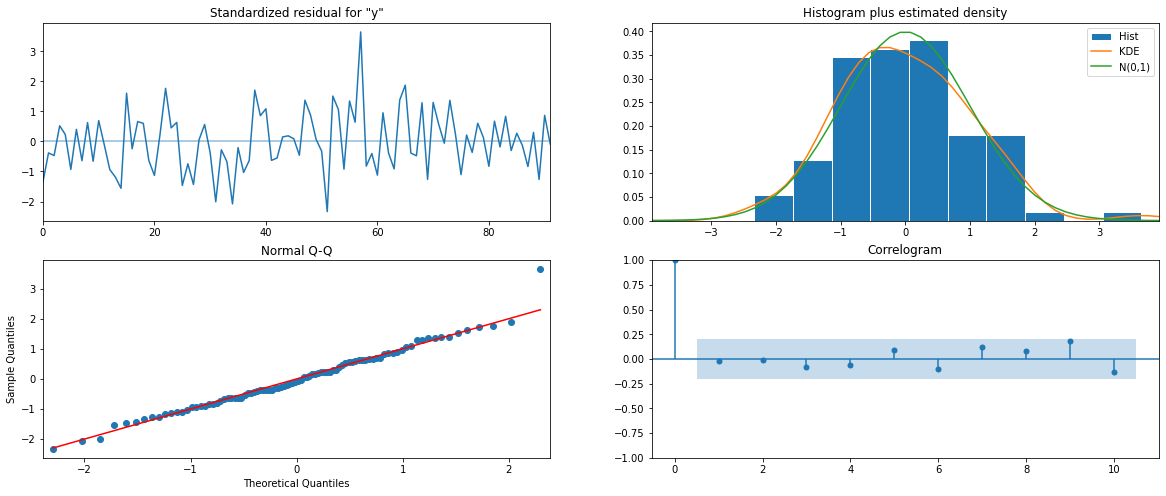

In [876]:
results_auto_SARIMA.plot_diagnostics()
plt.show()

### The above 4 plots in the residuals diagnostic plots tell us: 

- **Standardized residuals plot**: <i>The top left plot shows 1-step-ahead standardized residuals. 
    If model is working correctly, then no pattern should be obvious in the residuals which is clearly not visible from the plot as well .</i>



- **Histogram plus estimated density plot**: <i>This plot shows the distribution of the residuals.The orange line shows a smoothed version of this histogram, and the green line shows a normal distribution. If the model is good these two lines should be the same. Here there are small differences between them, which indicate that our model is doing just well enough.</i>



- **Normal Q-Q plot**: <i>The Q-Q plot compare the distribution of residuals to normal distribution. If the distribution of the residuals is normal, then all the points should lie along the red line, except for some values at the end, which is exactly happening in this case.</i>



- **Correlogram plot**: <i>The correlogram plot is the ACF plot of the residuals rather than the data. 95% of the correlations for lag >0  should not be significant (within the blue shades). If there is a significant correlation in the residuals, it means that there is information in the data that was not captured by the model, which is clearly not in this case</i> .

#### Forecasting using this model for the duration of the test set


In [877]:
predicted_auto_SARIMA = results_auto_SARIMA.get_forecast(steps=len(test))

In [878]:
predicted_auto_SARIMA.summary_frame(alpha=0.05).head()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,44.213668,14.221691,16.339665,72.087671
1,62.326832,14.300461,34.298443,90.355221
2,67.313397,14.302367,39.281273,95.345521
3,63.161020,14.305273,35.123201,91.198840
4,66.474514,14.310648,38.426159,94.522868


In [879]:
pred_auto_SARIMA_date = predicted_auto_SARIMA.summary_frame(alpha=0.05).set_index(pd.date_range(start='1991-01-01',end='1995-08-01', freq='M'))

In [880]:
rmse = mse(test['Rose'],predicted_auto_SARIMA.predicted_mean,squared=False)
print(rmse)

16.391124086518364


#### Plotting the Training data, Test data and the forecasted values with confidence band

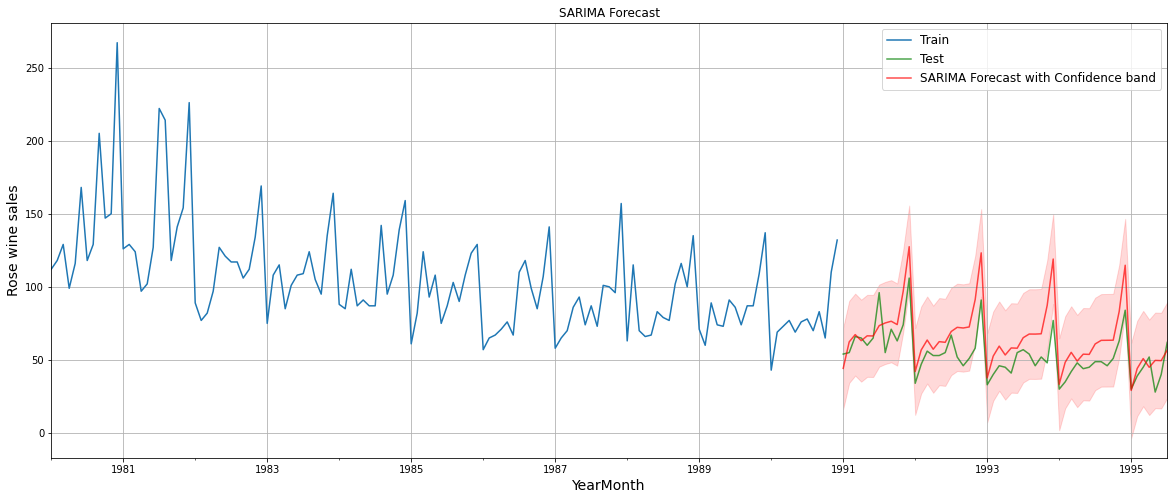

In [881]:
axis = train['Rose'].plot(label='Train')
test['Rose'].plot(ax=axis, label='Test',color='g', alpha=0.7)
pred_auto_SARIMA_date['mean'].plot(ax=axis, label='SARIMA Forecast with Confidence band', color='r', alpha=0.7)
axis.fill_between(pred_auto_SARIMA_date.index, pred_auto_SARIMA_date['mean_ci_lower'], 
                  pred_auto_SARIMA_date['mean_ci_upper'], color='r', alpha=.15)
axis.set_xlabel('YearMonth', fontsize=14)
axis.set_ylabel('Rose wine sales', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.title('SARIMA Forecast')
plt.grid()
plt.show()

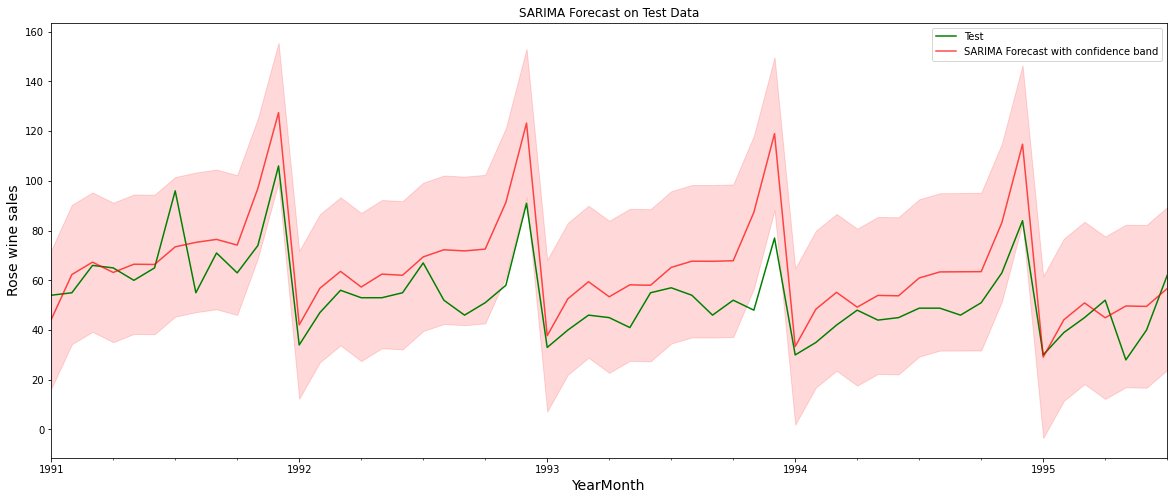

In [882]:
axis = test['Rose'].plot(label='Test',color='g')
pred_auto_SARIMA_date['mean'].plot(ax=axis, label='SARIMA Forecast with confidence band', color='r', alpha=0.7)
axis.fill_between(pred_auto_SARIMA_date.index, pred_auto_SARIMA_date['mean_ci_lower'], 
                  pred_auto_SARIMA_date['mean_ci_upper'], color='r', alpha=.15)
axis.set_xlabel('YearMonth', fontsize=14)
axis.set_ylabel('Rose wine sales', fontsize=14)
plt.legend(loc='best')
plt.title('SARIMA Forecast on Test Data')
plt.show()

### Model Evaluation

In [883]:
rmse_model10_test = mse(test['Rose'],predicted_auto_SARIMA.predicted_mean,squared=False)
print("For SARIMA forecast on the Test Data,  RMSE is %3.3f" %(rmse_model10_test))


For SARIMA forecast on the Test Data,  RMSE is 16.391


In [884]:
resultsDf_10 = pd.DataFrame({'Test RMSE': [rmse_model10_test]}
                           ,index=['SARIMA_forecast'])

resultsDf = pd.concat([resultsDf, resultsDf_10])
resultsDf

,Test RMSE
LnR_forecast,15.238125
Naive_forecast,79.590941
SimpleAvg_forecast,53.330686
Simple_Exp_Smoothing_forecast,36.665694
Double_Exp_Smoothing_forecast,15.239142
Triple_Exp_additive_Smoothing_forecast,14.186164
Triple_Exp_multiplicative_Smoothing_forecast,19.041869
Brute_force_Triple_Exp_multiplicative_Smoothing_forecast,10.215033
ARIMA_forecast,37.176466
SARIMA_forecast,16.391124


----

# 1.7) Build a table (create a data frame) with all the models built along with their corresponding parameters and the respective RMSE values on the test data.

## Final comparison of all the models:

In [885]:
# Define the model names
model_names = [
    'Linear Regression',
    'Naive',
    'Simple Average',
    'Simple Exponential Smoothing',
    'Double Exponential Smoothing',
    'Triple Exponential Additive Smoothing',
    'Triple Exponential Multiplicative Smoothing',
    'Brute forced Triple Exponential Multiplicative Smoothing',
    'ARIMA',
    'SARIMA']

# Define the model parameters
model_parameters = [
    'NA',
    'NA',
    'NA',
    'alpha: 0.098 ',
    'alpha: 9.90, beta: 0.0',
    'alpha: 0.088, beta: 5.48e-05, gamma: 0.001',
    'alpha: 0.077, beta: 0.04, gamma: 0.00085',
    'alpha: 0.3,  beta: 0.3,   gamma: 0.4',
    '(p, d, q): (0,1,2)',
    '(p, d, q): (0,1,2), (P, D, Q, S): (2,1,2,12)']

# Define the RMSE values on the test data
rmse_values = [
    15.238125,
    79.590941,
    53.330686,
    36.665694,
    15.239142,
    14.186164,
    19.041869,
    10.215033,
    37.176466,
    16.391124]


pd.set_option('display.max_colwidth', None) 
# Create the DataFrame
Model_performance_table = pd.DataFrame({'Model': model_names, 'Parameters': model_parameters, 
                                        'Test RMSE': rmse_values})

# Display the DataFrame
Model_performance_table


,Model,Parameters,Test RMSE
0,Linear Regression,NA,15.238125
1,Naive,NA,79.590941
2,Simple Average,NA,53.330686
3,Simple Exponential Smoothing,alpha: 0.098,36.665694
4,Double Exponential Smoothing,"alpha: 9.90, beta: 0.0",15.239142
5,Triple Exponential Additive Smoothing,"alpha: 0.088, beta: 5.48e-05, gamma: 0.001",14.186164
6,Triple Exponential Multiplicative Smoothing,"alpha: 0.077, beta: 0.04, gamma: 0.00085",19.041869
7,Brute forced Triple Exponential Multiplicative Smoothing,"alpha: 0.3, beta: 0.3, gamma: 0.4",10.215033
8,ARIMA,"(p, d, q): (0,1,2)",37.176466
9,SARIMA,"(p, d, q): (0,1,2), (P, D, Q, S): (2,1,2,12)",16.391124


In [886]:
Model_performance_table.sort_values(by=['Test RMSE'])


,Model,Parameters,Test RMSE
7,Brute forced Triple Exponential Multiplicative Smoothing,"alpha: 0.3, beta: 0.3, gamma: 0.4",10.215033
5,Triple Exponential Additive Smoothing,"alpha: 0.088, beta: 5.48e-05, gamma: 0.001",14.186164
0,Linear Regression,NA,15.238125
4,Double Exponential Smoothing,"alpha: 9.90, beta: 0.0",15.239142
9,SARIMA,"(p, d, q): (0,1,2), (P, D, Q, S): (2,1,2,12)",16.391124
6,Triple Exponential Multiplicative Smoothing,"alpha: 0.077, beta: 0.04, gamma: 0.00085",19.041869
3,Simple Exponential Smoothing,alpha: 0.098,36.665694
8,ARIMA,"(p, d, q): (0,1,2)",37.176466
2,Simple Average,NA,53.330686
1,Naive,NA,79.590941


----

---

# 1.8) Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.

In [887]:
resultsDf.sort_values(by=['Test RMSE'])

,Test RMSE
Brute_force_Triple_Exp_multiplicative_Smoothing_forecast,10.215033
Triple_Exp_additive_Smoothing_forecast,14.186164
LnR_forecast,15.238125
Double_Exp_Smoothing_forecast,15.239142
SARIMA_forecast,16.391124
Triple_Exp_multiplicative_Smoothing_forecast,19.041869
Simple_Exp_Smoothing_forecast,36.665694
ARIMA_forecast,37.176466
SimpleAvg_forecast,53.330686
Naive_forecast,79.590941


#### As we can see based on the test rmse values top 2 models are both triple exponential smoothing models , therefore the final model and the best performing one is brute forced triple exponential smoothing model with multiplicative errors.

## Final model: 
## Using Brute force method to get best parameters (alpha, beta and gamma) for Holt Winter's linear method with multiplicative errors 

In [888]:
# Initializing the triple Exponential Smoothing Model
final_mult = ExponentialSmoothing(df1,trend='add',seasonal='multiplicative',initialization_method='estimated')
# Fitting the model
final_mult_autofit = final_mult.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(final_mult.params)


==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.10736883194313922, 'smoothing_trend': 1.1443110284903084e-06, 'smoothing_seasonal': 8.09467754156691e-05, 'damping_trend': nan, 'initial_level': 122.97378343435987, 'initial_trend': -0.46601749651493146, 'initial_seasons': array([0.87719685, 0.99632079, 1.09898428, 0.98202738, 1.07346434,
       1.16259947, 1.30560331, 1.34532034, 1.26915884, 1.25450854,
       1.45613743, 2.0072    ]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [889]:
final_model_predict = final_mult_autofit.forecast(12)
final_model_predict

1995-08-01    47.807332
1995-09-01    44.512041
1995-10-01    43.414459
1995-11-01    49.713814
1995-12-01    67.591291
1996-01-01    29.128329
1996-02-01    32.622089
1996-03-01    35.471958
1996-04-01    31.241851
1996-05-01    33.646175
1996-06-01    35.898206
1996-07-01    39.705887
Freq: MS, dtype: float64

In [890]:
final_model_train=df1.copy()

In [891]:
# Create an empty DataFrame to store the metrics
final_model_metrics = pd.DataFrame(columns=['Alpha Values', 'Beta Values', 'Gamma Values', 'Test RMSE'])
final_model_metrics

,Alpha Values,Beta Values,Gamma Values,Test RMSE


In [892]:

# Initialize an empty dictionary to store predicted values
final_model_predicted = {}

# Nested loops to iterate over different parameter values
for i in np.arange(0.3, 1.1, 0.1):
    for j in np.arange(0.3, 1.1, 0.1):
        for k in np.arange(0.3, 1.1, 0.1):
            final_model1_metrics_i_j_k = final_mult.fit(smoothing_level=i, smoothing_trend=j, smoothing_seasonal=k, optimized=False, use_brute=True)
            
        
            pred_values = ('predict', i, j, k)
            
            # Store the predicted values
            final_model_predicted[pred_values] = final_model1_metrics_i_j_k.forecast(steps=12)
            
            # Calculate RMSE
            rmse_final_model = mse(df1['Rose'][-12:], final_model_predicted[pred_values], squared=False)
            final_model_metrics = pd.concat([final_model_metrics, pd.DataFrame({'Alpha Values': i, 'Beta Values': j, 'Gamma Values': k,
                                                                                  'Test RMSE': rmse_final_model1},
                                                         index=[0])], ignore_index=True)
    



In [893]:
final_model_metrics

,Alpha Values,Beta Values,Gamma Values,Test RMSE
0,0.3,0.3,0.3,6.668738
1,0.3,0.3,0.4,6.668738
2,0.3,0.3,0.5,6.668738
3,0.3,0.3,0.6,6.668738
4,0.3,0.3,0.7,6.668738
...,...,...,...,...
507,1.0,1.0,0.6,6.668738
508,1.0,1.0,0.7,6.668738
509,1.0,1.0,0.8,6.668738
510,1.0,1.0,0.9,6.668738


In [894]:
final_model_metrics.sort_values(by=['Test RMSE']).head()


,Alpha Values,Beta Values,Gamma Values,Test RMSE
0,0.3,0.3,0.3,6.668738
349,0.8,0.6,0.8,6.668738
348,0.8,0.6,0.7,6.668738
347,0.8,0.6,0.6,6.668738
346,0.8,0.6,0.5,6.668738


Plotting the complete data alongwith forecasted values using brute force alpha, beta and gamma determination


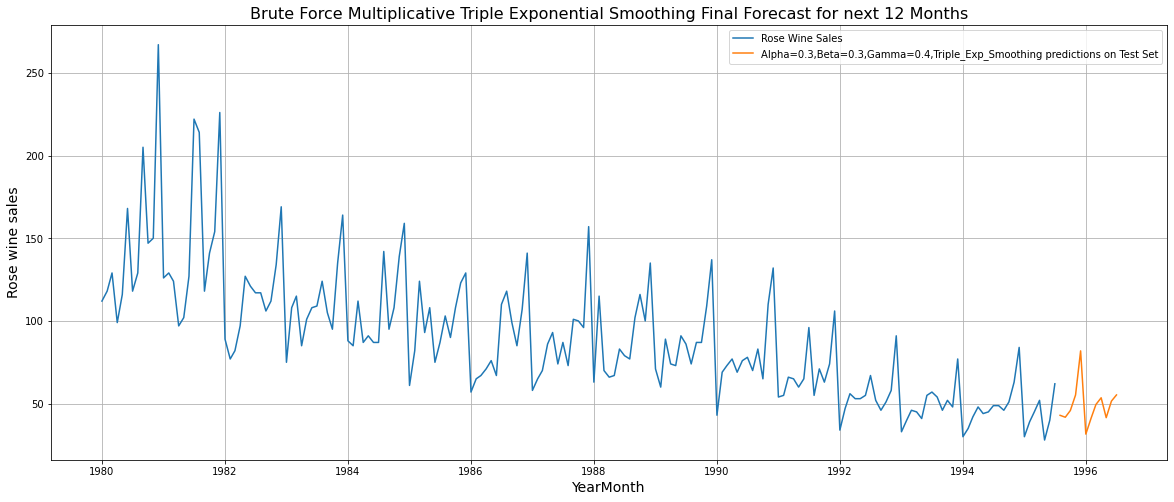

In [895]:
plt.plot(df1['Rose'], label='Rose Wine Sales')

plt.plot(final_model_predicted['predict', 0.4, 0.3, 0.3], label='Alpha=0.3,Beta=0.3,Gamma=0.4,Triple_Exp_Smoothing predictions on Test Set')

plt.legend(loc='best', fontsize=10)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Rose wine sales', fontsize=14)
plt.title('Brute Force Multiplicative Triple Exponential Smoothing Final Forecast for next 12 Months', fontsize=16)
plt.grid();

In [896]:
rmse_final_model = final_model_metrics.sort_values(by=['Test RMSE']).values[0][3]

In [897]:
print("For 12 months forecast on the complete data using triple exp smoothing where (⍺,β,𝛄)=(0.4,0.3,0.3),\nRMSE is %3.3f" %(rmse_final_model))


For 12 months forecast on the complete data using triple exp smoothing where (⍺,β,𝛄)=(0.4,0.3,0.3),
RMSE is 6.669


In [898]:
resultsDf_final_model = pd.DataFrame({'Model RMSE': [rmse_final_model]}
                           ,index=['⍺=0.4,β=0.3,𝛄=0.3,Triple_Expo_Smoothing_full_data'])

resultsDf_final_model

,Model RMSE
"⍺=0.4,β=0.3,𝛄=0.3,Triple_Expo_Smoothing_full_data",6.668738


# END